# Import

In [ ]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

from scipy.stats import chi2_contingency
from scipy.stats import shapiro

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# Function

In [ ]:
def variance_inflation_factors(df):
    X = df.assign(const=1)
    vif_df = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    return vif_df.reset_index(name="VIF")

def remove_multicollinearity_vif(df, list_):
  i = 1
  df_temp = df[list_].copy()

  while i > 0:
    vif_df = variance_inflation_factors(df_temp).sort_values(['VIF'],ascending=False)
    vif_df = vif_df[vif_df['VIF'] > 5]
    vif_df = vif_df[vif_df['index'] != 'const']

    if not vif_df.empty:
      print("=========================== Remove High VIF Variables ===========================")
      print("")
      print(vif_df.head(1)['index'].values,vif_df.head(1)['VIF'].round(2).values)
      list_.remove(vif_df.head(1)['index'].values)
      df_temp = df[list_].copy()
      i=+1
      print("")
    else:
      i = 0

  return

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
loan_df = pd.read_csv("loan.csv", parse_dates=['applicationDate', 'originatedDate'])

clarity_df = pd.read_csv("clarity_underwriting_variables.csv")
clarity_df.columns = [i.split('.')[-1] for i in clarity_df.columns]

payment_df = pd.read_csv("payment.csv", parse_dates=['paymentDate'])

# Parameter

This session consolidates all the parameters set in this study.

In [ ]:
# Define List
bad_loan_list = ['Charged Off Paid Off','External Collection','Internal Collection','Settled Bankruptcy','Charged Off']
good_loan_list = ['Paid Off Loan','Settlement Paid Off']
paid_off_list = ['Charged Off Paid Off','Paid Off Loan','Settlement Paid Off']

# Define out-of-time validation sample window
oot_year = 2017

# Statistical Test
alpha = 0.05

# Small Value
smallvalue = 1.e-17

# Introduction

This study is conducted based on the following assumptions:
1. *loan.csv* contains all historical loan records
2. *payment.csv* contains all loan payment records
3. **Charged Off Paid Off, External Collection, Internal Collection, Settled Bankruptcy and Charged Off** are defined as bad loan

The problem statement of this data science analysis is to identify potential bad loaners, whom having high loan risk from the loan application, before the loan is being approved and the loan is funded to the borrowers.

The purpose of predicting loans application with high risk is to avoid or minmize financial losses to lenders because it allows lenders to assess the likelihood of borrowers defaulting on their loans.

# Data Exploration

In [ ]:
loan = loan_df.copy()
loan.isnull().sum()

loanId                                 256
anon_ssn                                 0
payFrequency                          1273
apr                                   3922
applicationDate                          0
originated                               0
originatedDate                      531638
nPaidOff                                24
approved                                 0
isFunded                                 0
loanStatus                             391
loanAmount                            2250
originallyScheduledPaymentAmount         0
state                                  132
leadType                                 0
leadCost                                 0
fpStatus                            525959
clarityFraudId                      219989
hasCF                                    0
dtype: int64

In [ ]:
loan['loanid_flag'] = '2) With Loan ID'
loan.loc[loan['loanId'].isnull(),'loanid_flag'] = '1) Without Loan ID'

loan['application_flag'] = '2) Applied'
loan.loc[loan['applicationDate'].isnull(),'application_flag'] = '1) Not Applied'

loan['underwriting_flag'] = '2) Underwriting'
loan.loc[loan['clarityFraudId'].isnull(),'underwriting_flag'] = '1) No Underwriting'

loan['originate_flag'] = '2) Originated'
loan.loc[loan['originatedDate'].isnull(),'originate_flag'] = '1) Not Originated'

loan['approval_flag'] = '2) Approved'
loan.loc[(loan['approved']==False),'approval_flag'] = '1) Not Approved'

loan['voided_flag'] = '1) Not Voided'
loan.loc[loan['loanStatus'].fillna('nan').str.contains('Void'),'voided_flag'] = '2) Voided'

loan['funded_flag'] = '2) Funded'
loan.loc[loan['isFunded']==0,'funded_flag'] = '1) Not Funded'

loan['loanstatus_flag'] = '2) With Loan Status'
loan.loc[loan['loanStatus'].isnull(),'loanstatus_flag'] = '1) Without Loan Status'

In [ ]:
loan.groupby(['application_flag', 'loanid_flag','underwriting_flag',
              'originate_flag', 'approval_flag', 'voided_flag', 'funded_flag','loanstatus_flag']).size().reset_index(name='Loan Count')

application_flag         loanid_flag   underwriting_flag  \
0        2) Applied  1) Without Loan ID  1) No Underwriting   
1        2) Applied  1) Without Loan ID     2) Underwriting   
2        2) Applied     2) With Loan ID  1) No Underwriting   
3        2) Applied     2) With Loan ID  1) No Underwriting   
4        2) Applied     2) With Loan ID  1) No Underwriting   
5        2) Applied     2) With Loan ID  1) No Underwriting   
6        2) Applied     2) With Loan ID  1) No Underwriting   
7        2) Applied     2) With Loan ID  1) No Underwriting   
8        2) Applied     2) With Loan ID  1) No Underwriting   
9        2) Applied     2) With Loan ID  1) No Underwriting   
10       2) Applied     2) With Loan ID     2) Underwriting   
11       2) Applied     2) With Loan ID     2) Underwriting   
12       2) Applied     2) With Loan ID     2) Underwriting   
13       2) Applied     2) With Loan ID     2) Underwriting   
14       2) Applied     2) With Loan ID     2) Underwriting   
15       2) Applied     2) With Loan ID     2) Underwriting   
16       2) Applied     2) With Loan ID     2) Underwriting   
17       2) Applied     2) With Loan ID     2) Underwriting   

       originate_flag    approval_flag    voided_flag    funded_flag  \
0   1) Not Originated  1) Not Approved  1) Not Voided  1) Not Funded   
1   1) Not Originated  1) Not Approved  1) Not Voided  1) Not Funded   
2   1) Not Originated  1) Not Approved  1) Not Voided  1) Not Funded   
3   1) Not Originated  1) Not Approved  1) Not Voided  1) Not Funded   
4   1) Not Originated  1) Not Approved      2) Voided  1) Not Funded   
5       2) Originated  1) Not Approved  1) Not Voided  1) Not Funded   
6       2) Originated  1) Not Approved      2) Voided  1) Not Funded   
7       2) Originated      2) Approved  1) Not Voided  1) Not Funded   
8       2) Originated      2) Approved  1) Not Voided      2) Funded   
9       2) Originated      2) Approved      2) Voided  1) Not Funded   
10  1) Not Originated  1) Not Approved  1) Not Voided  1) Not Funded   
11  1) Not Originated  1) Not Approved  1) Not Voided  1) Not Funded   
12  1) Not Originated  1) Not Approved      2) Voided  1) Not Funded   
13      2) Originated  1) Not Approved  1) Not Voided  1) Not Funded   
14      2) Originated  1) Not Approved      2) Voided  1) Not Funded   
15      2) Originated      2) Approved  1) Not Voided  1) Not Funded   
16      2) Originated      2) Approved  1) Not Voided      2) Funded   
17      2) Originated      2) Approved      2) Voided  1) Not Funded   

           loanstatus_flag  Loan Count  
0   1) Without Loan Status         151  
1   1) Without Loan Status         105  
2   1) Without Loan Status          45  
3      2) With Loan Status      212865  
4      2) With Loan Status         124  
5      2) With Loan Status         104  
6      2) With Loan Status           1  
7      2) With Loan Status           2  
8      2) With Loan Status        6622  
9      2) With Loan Status          75  
10  1) Without Loan Status          90  
11     2) With Loan Status      317195  
12     2) With Loan Status        1063  
13     2) With Loan Status        5900  
14     2) With Loan Status           3  
15     2) With Loan Status           6  
16     2) With Loan Status       32360  
17     2) With Loan Status         971

After the brief exploration on the provided data set. It is observed that the process of loan application as per following:

1. Customer submits loan application, loanId is will be generated.
2. Customer profile will be undergoes underwriting to evaluates the borrower's creditworthiness.
3. Once underwriting process is completed, and the borrower is deemed eligible for the loan, the loan is originated.
4. After the loan is originated, the loan will pass to approval process.
5. Once the loan is approved, the lender will disburse the funds to the borrowers.

It is noted that:
1. Not all loan application will go through underwriting process, for loan that does not go through underwriting process, it will directly flow to orgination process.
2. Loan application can be voided at any stage of loan application.

# Feature Engineering

## Numerical Variables

To predict the loan application with high risk, it is important to look into several areas, including credit score of the borrowers, by analyzing the borrower's creditworthiness based on their credit history.

From the data provided, *payment.csv* is the best data option we can analyze the historical payment behaviour

Hence, new features are created based on business understanding from *payment.csv* and *loan.csv*:
1. **Previous loan Count** : The number of previous funded loan
2. **Previous Bad Loan Count** : The number of previous funded loan that has turned into bad loan
3. **Previous Paid Off Loan Count** : The number of previous funded loan that has been paid off
4. **Difference between full payment and Originally Scheduled Payment Amount** : The difference in term of the full payment made to lenders and the Originally Scheduled Payment Amount for the previous loan
5. **Existing Debt Amount (RM)** : The total amount of debt based on the previous funded loan that has not been paid off
6. **Previous Payment is Collection** : The number of payment that is collection for the previous loan
7. **Number of Success Payment Made** : The number of Success payment made for the previous loan
8. **Number of Failed Payment Made** : The number of Failed payment made for the previous loan
9. **Median Payment Amount (RM) of Success Payment Made** : The median Payment Amount (RM) of Success Payment Made for the previous loan
10. **Median Payment Amount (RM) of Failed Payment Made** : The median Payment Amount (RM) of Failed Payment Made for the previous loan

In [ ]:
hist_df = loan_df[loan_df['isFunded'] == 1].reset_index(drop=True)


hist_df['bad_loan'] = np.nan
hist_df.loc[hist_df['loanStatus'].isin(bad_loan_list),'bad_loan'] = 1
hist_df.loc[hist_df['loanStatus'].isin(good_loan_list),'bad_loan'] = 0

In [ ]:
hist_df.dropna(subset=['bad_loan'])['bad_loan'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')

1.0    58.89%
0.0    41.11%
Name: bad_loan, dtype: object

In [ ]:
id_lst = []
num_prev_loan_lst = []
num_prev_bad_loan_lst = []
num_prev_paid_off_lst = []
diff_prev_paid_off_schedu_amt_lst = []
amt_prev_debt_lst = []
prev_iscollection_lst = []
num_success_payment_lst = []
num_failed_payment_lst = []
med_success_payment_lst = []
med_failed_payment_lst = []

start_time = time.time()

for id_ in hist_df['loanId'].unique():
  id = id_
  ssn = hist_df[hist_df['loanId'] == id_]['anon_ssn'].values[0]
  appl_dt = hist_df[hist_df['loanId'] == id_]['applicationDate'].values[0]
  orginated_dt = hist_df[hist_df['loanId'] == id_]['originatedDate'].values[0]

  # of prev loan
  prev_loan_df = hist_df[(hist_df['anon_ssn'] == ssn)&(hist_df['applicationDate'] < appl_dt)]
  if prev_loan_df.empty:
    num_prev_loan = 0
    bad_num_prev_loan = 0
    num_prev_paidoff = 0
    num_prev_paidoff_vs_orgsche_amt = 0
    debt_amt = 0
    num_iscollection = 0
    num_failed_payment = 0
    num_success_payment = 0
    med_success_payment_amt = 0
    med_failed_payment_amt = 0

  else:
    num_prev_loan = prev_loan_df.shape[0]

    # of prev bad loan
    bad_prev_loan_df = prev_loan_df[prev_loan_df['loanStatus'].isin(bad_loan_list)]
    if bad_prev_loan_df.empty:
      bad_num_prev_loan = 0
    else:
      bad_num_prev_loan = bad_prev_loan_df.shape[0]

    # of prev paid off loan
    prev_payment_df = payment_df[payment_df['loanId'].isin(prev_loan_df['loanId'].unique())].reset_index(drop=True)
    prev_payment_df = prev_payment_df.merge(prev_loan_df[['loanId','loanStatus','originallyScheduledPaymentAmount']],on='loanId' ,how='left')

    paid_prev_payment_df = prev_payment_df[prev_payment_df['paymentStatus'].isin(['Checked','Complete'])].reset_index(drop=True)
    max_paid_prev_payment_df = paid_prev_payment_df.groupby(['loanId','loanStatus','originallyScheduledPaymentAmount']).agg({'paymentDate':np.nanmax,'paymentAmount':np.nansum}).reset_index()
    max_paid_prev_payment_df['application_date'] = appl_dt
    for_paid_prev_payment_df = max_paid_prev_payment_df[(max_paid_prev_payment_df['paymentDate'] < max_paid_prev_payment_df['application_date'])
                                                        & (max_paid_prev_payment_df['loanStatus'].isin(paid_off_list))]

    if for_paid_prev_payment_df.empty:
      num_prev_paidoff = 0
      num_prev_paidoff_vs_orgsche_amt = 0

    else:
      num_prev_paidoff = for_paid_prev_payment_df.shape[0]
      num_prev_paidoff_vs_orgsche_amt = for_paid_prev_payment_df['paymentAmount'].sum() - for_paid_prev_payment_df['originallyScheduledPaymentAmount'].sum()

    # of prev debt
    prev_payment_df['application_date'] = appl_dt
    for_debt_prev_payment_df = prev_payment_df[(prev_payment_df['paymentStatus'].isin(['Checked','Complete','None','Pending']))
                                              &(prev_payment_df['paymentDate'] > prev_payment_df['application_date'])].reset_index(drop=True)

    if for_debt_prev_payment_df.empty:
      debt_amt = 0
    else:
      debt_amt = for_debt_prev_payment_df['paymentAmount'].sum()

    # of prev isCollection
    paid_prev_payment_df['isCollection_int'] = 0
    paid_prev_payment_df.loc[paid_prev_payment_df['isCollection']==True,'isCollection_int'] = 1
    paid_prev_payment_df['anon_ssn'] = ssn
    paid_prev_payment_df['application_date'] = appl_dt
    paid_prev_payment_df = paid_prev_payment_df[paid_prev_payment_df['paymentDate'] < paid_prev_payment_df['application_date']].reset_index(drop=True)
    if paid_prev_payment_df.empty:
      num_iscollection = 0
    else:
      num_iscollection = paid_prev_payment_df['isCollection_int'].sum()


    # of success and rejected payment
    prev_payment_hist_record_df = prev_payment_df[prev_payment_df['paymentDate'] < prev_payment_df['application_date']].reset_index(drop=True)
    prev_payment_hist_record_df['payment_status'] = np.nan
    prev_payment_hist_record_df.loc[prev_payment_hist_record_df['paymentStatus'].isin(['Checked','Complete']),'payment_status'] = 'Success'
    prev_payment_hist_record_df.loc[prev_payment_hist_record_df['paymentStatus'].isin(['Rejected','Rejected Awaiting Retry','Returned']),'payment_status'] = 'Failed'

    if prev_payment_hist_record_df.empty:
      num_failed_payment = 0
      num_success_payment = 0
      med_success_payment_amt = 0
      med_failed_payment_amt = 0
    else:
      num_failed_payment = prev_payment_hist_record_df[prev_payment_hist_record_df['payment_status'] == 'Failed'].shape[0]
      if num_failed_payment == 0:
        med_failed_payment_amt = 0
      else :
        med_failed_payment_amt = prev_payment_hist_record_df[prev_payment_hist_record_df['payment_status'] == 'Failed']['paymentAmount'].median()

      num_success_payment = prev_payment_hist_record_df[prev_payment_hist_record_df['payment_status'] == 'Success'].shape[0]
      if num_success_payment == 0:
        med_success_payment_amt = 0
      else :
        med_success_payment_amt = prev_payment_hist_record_df[prev_payment_hist_record_df['payment_status'] == 'Success']['paymentAmount'].median()


  id_lst.append(id)
  num_prev_loan_lst.append(num_prev_loan)
  num_prev_bad_loan_lst.append(bad_num_prev_loan)
  num_prev_paid_off_lst.append(num_prev_paidoff)
  diff_prev_paid_off_schedu_amt_lst.append(num_prev_paidoff_vs_orgsche_amt)
  amt_prev_debt_lst.append(debt_amt)
  prev_iscollection_lst.append(num_iscollection)
  num_success_payment_lst.append(num_success_payment)
  num_failed_payment_lst.append(num_failed_payment)
  med_success_payment_lst.append(med_success_payment_amt)
  med_failed_payment_lst.append(med_failed_payment_amt)

print("--- %s minutes ---" % np.round((time.time() - start_time)/60,2))

--- 22.17 minutes ---


In [ ]:
col = ['loanId','prevLoan_cnt','prevBadLoan_cnt','prevPaidOff_cnt','diffPaidOff_schedAmt','existDebt_amt','prev_IsCollection','numSuccess_payment','numFailed_payment','medSuccess_paymentAmt','medFailed_paymentAmt']

hist_df2 = pd.DataFrame(zip(id_lst,num_prev_loan_lst,num_prev_bad_loan_lst,num_prev_paid_off_lst,diff_prev_paid_off_schedu_amt_lst,
                            amt_prev_debt_lst,prev_iscollection_lst,
                            num_success_payment_lst,num_failed_payment_lst,med_success_payment_lst,med_failed_payment_lst),columns=col)

hist_df2 = hist_df.merge(hist_df2,on=['loanId'],how='left')

hist_df2 = hist_df2.merge(clarity_df.rename(columns={'underwritingid':'clarityFraudId'}),on=['clarityFraudId'],how='left')
hist_df2['diff_appl_orig_mins'] = (hist_df2['originatedDate']-hist_df2['applicationDate']).dt.seconds/60

print(hist_df.shape)
print(hist_df2.shape)

(38982, 20)
(38982, 84)


## Categorical Variables

Perform Chi-Square Test to see if there is any relation between two categorical variables (Predictor vs Target).

- $H_0$ : There is no relationship between two features
- $H_1$ : There is a relationship between two features

From the result below, the p-value is less than 0.05 which is statistically significant, hence there is sufficient evidence to reject null hypothesis. Hence, **State, Lead Type and Pay Frequency** have relationship with the target (Bad Loan)



In [ ]:
hist_df2['Year_Month'] = hist_df2['applicationDate'].dt.to_period('M')

In [ ]:
significant_cat_col = []

In [ ]:
chi_table = hist_df2[['loanId','applicationDate','bad_loan','state','leadType','payFrequency']]
chi_table = chi_table.reset_index(drop=True)
chi_table.dropna(subset=['bad_loan'],inplace=True)
chi_table = chi_table[chi_table['applicationDate'].dt.year < oot_year]
chi_table['bad_loan'] = chi_table['bad_loan'].astype(str)

cat_col = []
pvalue = []

for col_ in ['state','leadType','payFrequency']:
  crosstab =  pd.crosstab(chi_table['bad_loan'], chi_table[col_], margins=True, margins_name="subtotal")
  res = chi2_contingency(crosstab)
  p_ = np.round(res.pvalue,2)

  cat_col.append(col_)
  pvalue.append(p_)

chi_table_result = pd.DataFrame(zip(cat_col,pvalue),columns=['categorical','p_value'])

chi_table_result

<ipython-input-18-c606ced8942c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_table['bad_loan'] = chi_table['bad_loan'].astype(str)


categorical  p_value
0         state      0.0
1      leadType      0.0
2  payFrequency      0.0

From the result below, features below have relationship with the target (Bad Loan):
*   **Inquiry / on-file current address conflict**
*   **More than 3 inquiries in the last 30 days**
*   **Inquiry current address not on-file**
*   **high level indication of whether the name appears to belong with the address on the current application**
*   **high level indication of whether key personal information from the current application appears to belong together**
*   **nature of the ssn_dob match result Code**


In [ ]:
chi_table = hist_df2[['loanId','applicationDate','bad_loan']+clarity_df.drop(columns=['underwritingid']).select_dtypes('object').columns.to_list()]
chi_table = chi_table.reset_index(drop=True)
chi_table.dropna(subset=['bad_loan'],inplace=True)
chi_table = chi_table[chi_table['applicationDate'].dt.year < oot_year]
chi_table['bad_loan'] = chi_table['bad_loan'].astype(str)

cat_col = []
pvalue = []

for col_ in clarity_df.drop(columns=['underwritingid']).select_dtypes('object').columns.to_list():
  crosstab =  pd.crosstab(chi_table['bad_loan'], chi_table[col_], margins=True, margins_name="subtotal")
  res = chi2_contingency(crosstab)
  p_ = np.round(res.pvalue,2)

  cat_col.append(col_)
  pvalue.append(p_)

chi_table_result = pd.DataFrame(zip(cat_col,pvalue),columns=['categorical','p_value'])


for col_ in chi_table_result[chi_table_result['p_value'] < 0.05]['categorical'].unique().tolist():
  significant_cat_col.append(col_)

chi_table_result[chi_table_result['p_value'] < 0.05]

categorical  p_value
0   inquiryonfilecurrentaddressconflict     0.00
11    morethan3inquiriesinthelast30days     0.00
17       inquirycurrentaddressnotonfile     0.00
28                     nameaddressmatch     0.00
34                   overallmatchresult     0.00
36                     ssndobreasoncode     0.01

In [ ]:
drop_clarity_cat_col = chi_table_result[chi_table_result['p_value'] >= 0.05]['categorical'].unique().tolist()
hist_df2.drop(columns=drop_clarity_cat_col,inplace=True)

From the result below, states below have relationship with the target (Bad Loan):
> ['AL', 'AZ', 'CA', 'FL', 'IA', 'ID', 'IL', 'IN', 'KY','LA', 'MO', 'MS', 'NC', 'NJ', 'NV', 'OK', 'TN', 'TX', 'WI']


       

In [ ]:
hist_df3 = hist_df2.copy()

hist_df3_state = pd.get_dummies(hist_df3['state'])
hist_df3 = pd.concat([hist_df3,hist_df3_state],axis=1)

chi_table = hist_df3[['loanId','bad_loan','applicationDate']+list(hist_df3_state.columns)]
chi_table = chi_table.reset_index(drop=True)
chi_table.dropna(subset=['bad_loan'],inplace=True)
chi_table = chi_table[chi_table['applicationDate'].dt.year < oot_year]
chi_table['bad_loan'] = chi_table['bad_loan'].astype(str)

cat_col = []
pvalue = []

for state_ in hist_df3_state.columns:
  crosstab =  pd.crosstab(chi_table['bad_loan'], chi_table[state_], margins=True, margins_name="subtotal")
  res = chi2_contingency(crosstab)
  p_ = np.round(res.pvalue,2)

  cat_col.append(state_)
  pvalue.append(p_)

chi_table_result = pd.DataFrame(zip(cat_col,pvalue),columns=['categorical','p_value'])

for col_ in chi_table_result[chi_table_result['p_value'] < 0.05]['categorical'].unique().tolist():
  significant_cat_col.append(col_)

chi_table_result[chi_table_result['p_value'] < 0.05]

categorical  p_value
1           AL     0.00
2           AZ     0.02
3           CA     0.00
7           FL     0.00
10          IA     0.00
11          ID     0.01
12          IL     0.00
13          IN     0.02
15          KY     0.00
16          LA     0.00
20          MO     0.03
21          MS     0.00
22          NC     0.00
25          NJ     0.00
27          NV     0.02
29          OK     0.00
34          TN     0.00
35          TX     0.00
39          WI     0.00

In [ ]:
hist_df2 = hist_df3[list(hist_df2.columns)+list(chi_table_result[chi_table_result['p_value'] < 0.05]['categorical'].unique())].reset_index(drop=True)

payf_dict = {'W': 1, 'B': 2, 'S': 3,'M': 4,'I': 5}
hist_df2['payFrequency'] = hist_df2['payFrequency'].map(payf_dict)

From the result below, lead type below have relationship with the target (Bad Loan):
*   **by Mandatory**
*   **Express**
*   **Lead**
*   **Lion Pay**
*   **Organic**
*   **Pre-Screen**

In [ ]:
hist_df4 = hist_df2.copy()

hist_df4_leadType = pd.get_dummies(hist_df4['leadType'])
hist_df4 = pd.concat([hist_df4,hist_df4_leadType],axis=1)

chi_table = hist_df4[['loanId','bad_loan']+list(hist_df4_leadType.columns)]
chi_table = chi_table.reset_index(drop=True)
chi_table.dropna(subset=['bad_loan'],inplace=True)
chi_table['bad_loan'] = chi_table['bad_loan'].astype(str)

cat_col = []
pvalue = []

for leadType_ in hist_df4_leadType.columns:
  crosstab =  pd.crosstab(chi_table['bad_loan'], chi_table[leadType_], margins=True, margins_name="subtotal")
  res = chi2_contingency(crosstab)
  p_ = np.round(res.pvalue,2)

  cat_col.append(leadType_)
  pvalue.append(p_)

chi_table_leadType_result = pd.DataFrame(zip(cat_col,pvalue),columns=['categorical','p_value'])

for col_ in chi_table_leadType_result[chi_table_leadType_result['p_value'] < 0.05]['categorical'].unique().tolist():
  significant_cat_col.append(col_)

chi_table_leadType_result[chi_table_leadType_result['p_value'] < 0.05]

categorical  p_value
0   bvMandatory     0.00
2       express     0.04
4          lead     0.00
5       lionpay     0.01
6       organic     0.00
7     prescreen     0.00
8  rc_returning     0.00

In [ ]:
hist_df2 = hist_df4[list(hist_df2.columns)+list(chi_table_leadType_result[chi_table_leadType_result['p_value'] < 0.05]['categorical'].unique())].reset_index(drop=True)

# Data Validation

## (1) Clarify on nPaidOff
loanId = LL-I-17872310
<br>anon_ssn = a790684c26f4512cf710234b2e6eb439
<br>nPaidOff = 21.0
<br>prevPaidOff_cnt = 2


<br>From the loan.csv, the customer that has applied for this loan, has paid off 21 loans previously, as shown in **nPaidOff** field.

However, from the loan.csv, this customers have applied and paid off 2 loans only, that derived from feature engineering session described above.

Data scientist should further clarify with data providers on the source of truth or business to verify on the prevPaidOff_cnt is correct or not.

In [ ]:
hist_df2[hist_df2['loanId'] == 'LL-I-17872310'][['loanId','anon_ssn','applicationDate','nPaidOff','prevPaidOff_cnt']]

loanId                          anon_ssn         applicationDate  \
5858  LL-I-17872310  a790684c26f4512cf710234b2e6eb439 2017-03-02 15:07:52.786   

      nPaidOff  prevPaidOff_cnt  
5858      21.0                2

In [ ]:
loan_df[(loan_df['anon_ssn'] == 'a790684c26f4512cf710234b2e6eb439')
        &(loan_df['applicationDate'] < '2017-03-02 15:07:52.786')
        &(loan_df['loanStatus'].isin(paid_off_list))]

loanId                          anon_ssn payFrequency    apr  \
464714  LL-I-12179822  a790684c26f4512cf710234b2e6eb439            B  290.0   
485350  LL-I-14677649  a790684c26f4512cf710234b2e6eb439            B  265.0   

               applicationDate  originated          originatedDate  nPaidOff  \
464714 2016-11-20 19:25:29.614        True 2016-11-21 17:59:02.494      20.0   
485350 2017-01-09 17:06:51.519        True 2017-01-09 17:32:42.809      20.0   

        approved  isFunded     loanStatus  loanAmount  \
464714      True         1  Paid Off Loan       700.0   
485350      True         1  Paid Off Loan       600.0   

        originallyScheduledPaymentAmount state      leadType  leadCost  \
464714                           1385.58    PA  rc_returning         0   
485350                           1078.26    PA  rc_returning         0   

       fpStatus clarityFraudId  hasCF  
464714  Checked            NaN      0  
485350  Checked            NaN      0

In [ ]:
print("%s precent of the historical funded loans have the nPaidOff differs from prevPaidOff_cnt. " % np.round(hist_df2[hist_df2['nPaidOff'] !=  hist_df2['prevPaidOff_cnt']].shape[0]/hist_df2.shape[0]*100,2))

13.13 precent of the historical funded loans have the nPaidOff differs from prevPaidOff_cnt. 


## (2) Clarify on originallyScheduledPaymentAmount
Based on dictionary shared, understand that **originallyScheduledPaymentAmount** is the amount lenders should received if a customer has paid off all his scheduled payments.

<br>Derived feature named **fullpaymentAmount** is calculated from payment.csv, sum up to its loanId, by filtering out only success payment, where paymentStatus is in ['Checked','Complete'].

<br>Derived feature further compared with **originallyScheduledPaymentAmount**, and it is found that for all paid off loans, there is 77.27% of the paid off loans, where its **originallyScheduledPaymentAmount** does not match with **fullpaymentAmount**.

<br>Data scientist should further clarify with data providers on the source of truth.

In [ ]:
# Select only successful payments from payment.csv
temp_df = payment_df[payment_df['paymentStatus'].isin(['Checked','Complete'])].groupby(['loanId'])['paymentAmount'].sum().reset_index(name='fullpaymentAmount')

hist_df2 = hist_df2.merge(temp_df,on=['loanId'],how='left')

# As the loan is not paid off yet, hence the sum of total payment is not equal to full payment amount
hist_df2.loc[~hist_df2['loanStatus'].isin(paid_off_list),'fullpaymentAmount'] = np.nan

In [ ]:
print("%s precent of the historical funded paid off loans have the originallyScheduledPaymentAmount differs from sum of total payment received from payment.csv . "

      % np.round(

          hist_df2[(hist_df2['originallyScheduledPaymentAmount'] !=  hist_df2['fullpaymentAmount'])
          &(hist_df2['loanStatus'].isin(paid_off_list))].shape[0]

          /hist_df2[(hist_df2['loanStatus'].isin(paid_off_list))].shape[0]

          *100,2))

77.27 precent of the historical funded paid off loans have the originallyScheduledPaymentAmount differs from sum of total payment received from payment.csv . 


# Data Transformation

In this section, the following was carried out:

1. Normality Test:

  - $H_0$ : Numerical feature is normally distriuted
  - $H_1$ : Numerical column is not normally distributed.

  where if $p < 0.05$, it is statistically significant to reject the null hypothesis. Hence, there is sufficient evidence to conclude that numerical feature is not normally distributed.

2. From the above test, numerical features that are not normal are identified and transformed with the following steps (**these steps are only applicable to in-time training data**):

  1. The features are being scaled (i.e., Standard Scaler).
  2. Then, features are being scaled via Min Max Scaler which would restrict range of the numerical feature between [0, 1]
  3. The features are then further transformed via Yeo-Johnson Transformation so that the resulting features will be more normally distributed.

3. Out-time validation data will be transformed with the scaler trained from step [2]. The transformed data will be capped between [0,1]

Both non-normal features and transformed features are kept for model training performance comparison in the next section.

In [ ]:
# Selecting Samples with defined bad_loan target for this section onwards
if 'fullpaymentAmount' in hist_df2.columns:
  hist_df2.drop(columns=['fullpaymentAmount'],inplace=True)

df = hist_df2.copy()
df.dropna(subset=['bad_loan'],inplace=True)
df = df.reset_index(drop=True)

df['firstloan'] = 1
df.loc[df['prevLoan_cnt'] > 0,'firstloan'] = 0

in_time_df = df[df['applicationDate'].dt.year < oot_year].reset_index(drop=True)
out_time_df = df[df['applicationDate'].dt.year == oot_year].reset_index(drop=True)

In [ ]:
numerical_col = in_time_df.drop(columns=['bad_loan','isFunded','hasCF','payFrequency']).select_dtypes('float64').columns.to_list() + in_time_df.drop(columns=['firstloan','bad_loan','isFunded','hasCF','payFrequency']).select_dtypes('int64').columns.to_list()

num_col = []
p_value = []

for col_ in numerical_col:
  # normality test
  stat, p = shapiro(in_time_df[col_])

  num_col.append(col_)
  p_value.append(p)

shapiro_test = pd.DataFrame(zip(num_col,p_value),columns=['Numerical','p_value'])
shapiro_test[shapiro_test['p_value'] < alpha]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Numerical  p_value
0                                apr      0.0
2                         loanAmount      0.0
3   originallyScheduledPaymentAmount      0.0
4               diffPaidOff_schedAmt      0.0
5                      existDebt_amt      0.0
6              medSuccess_paymentAmt      0.0
7               medFailed_paymentAmt      0.0
21               diff_appl_orig_mins      0.0
22                          leadCost      0.0
23                      prevLoan_cnt      0.0
24                   prevBadLoan_cnt      0.0
25                   prevPaidOff_cnt      0.0
26                 prev_IsCollection      0.0
27                numSuccess_payment      0.0
28                 numFailed_payment      0.0

In [ ]:
normal_num_col = shapiro_test[shapiro_test['p_value'] >= alpha]['Numerical'].unique().tolist()
non_normal_num_col = shapiro_test[shapiro_test['p_value'] < alpha]['Numerical'].unique().tolist()

In [ ]:
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
pt = PowerTransformer()

# in time
scaler.fit(in_time_df[non_normal_num_col])
minmax_scaler.fit(scaler.transform(in_time_df[non_normal_num_col]))
pt.fit(minmax_scaler.transform(scaler.transform(in_time_df[non_normal_num_col])))
scale_df = pd.DataFrame(pt.transform(minmax_scaler.transform(scaler.transform(in_time_df[non_normal_num_col]))),columns=[i+"_transform" for i in non_normal_num_col])

# fit out time
scaler_out_df = pd.DataFrame(minmax_scaler.transform(scaler.transform(out_time_df[non_normal_num_col])),columns=[i+"_transform" for i in non_normal_num_col])
scaler_out_df.clip(upper=1,inplace=True)
scaler_out_df.clip(lower=0,inplace=True)

scaler_out_df = pd.DataFrame(pt.transform(scaler_out_df),columns=[i+"_transform" for i in non_normal_num_col])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


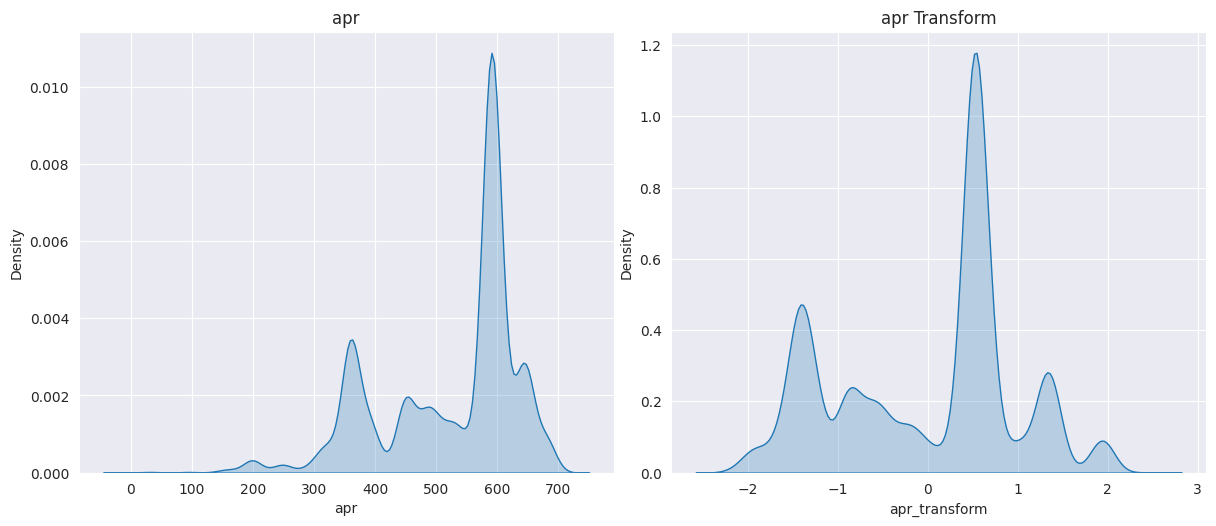

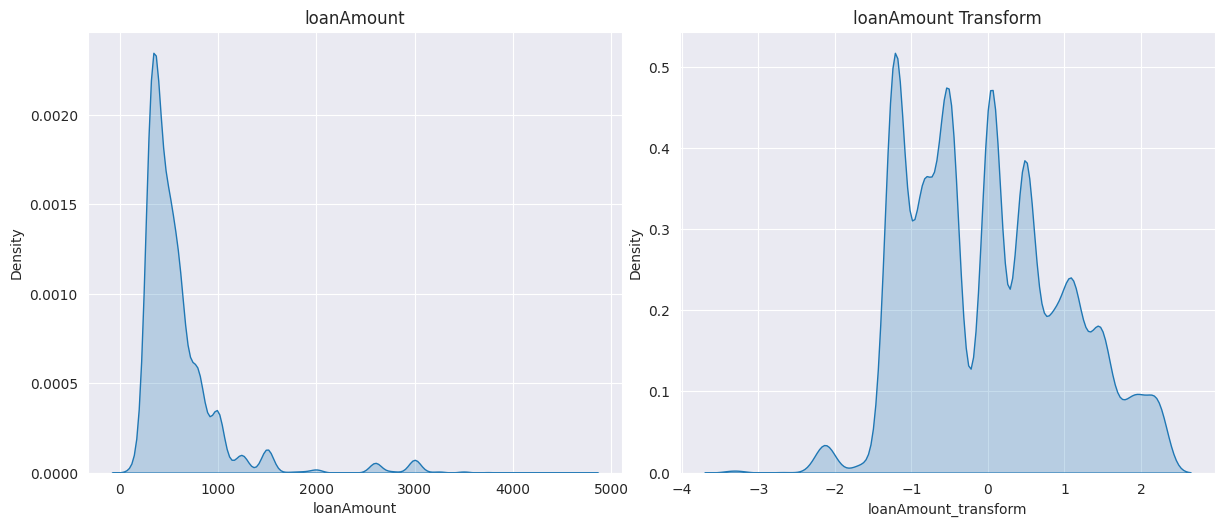

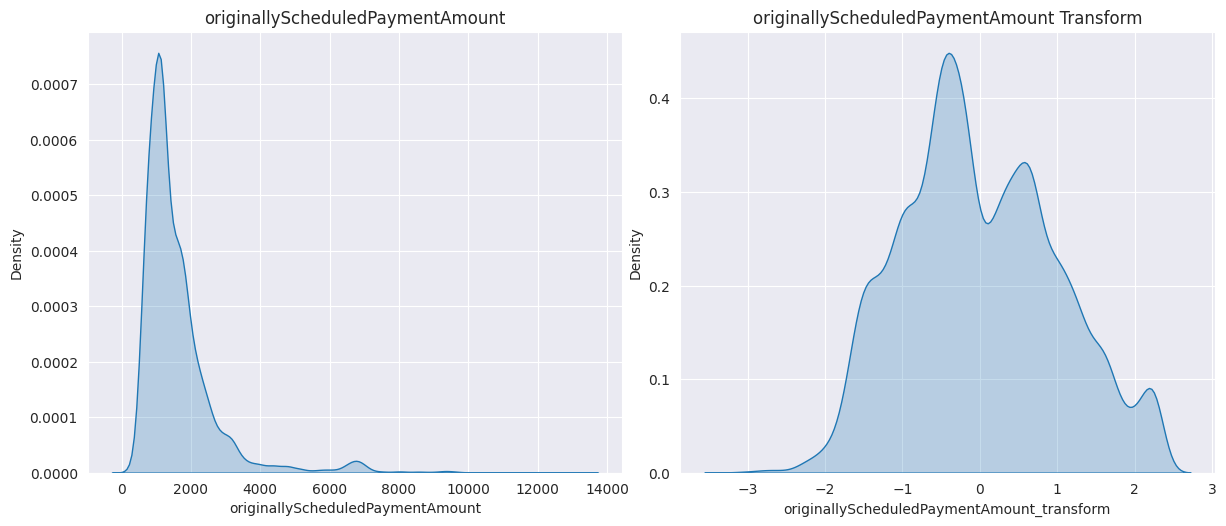

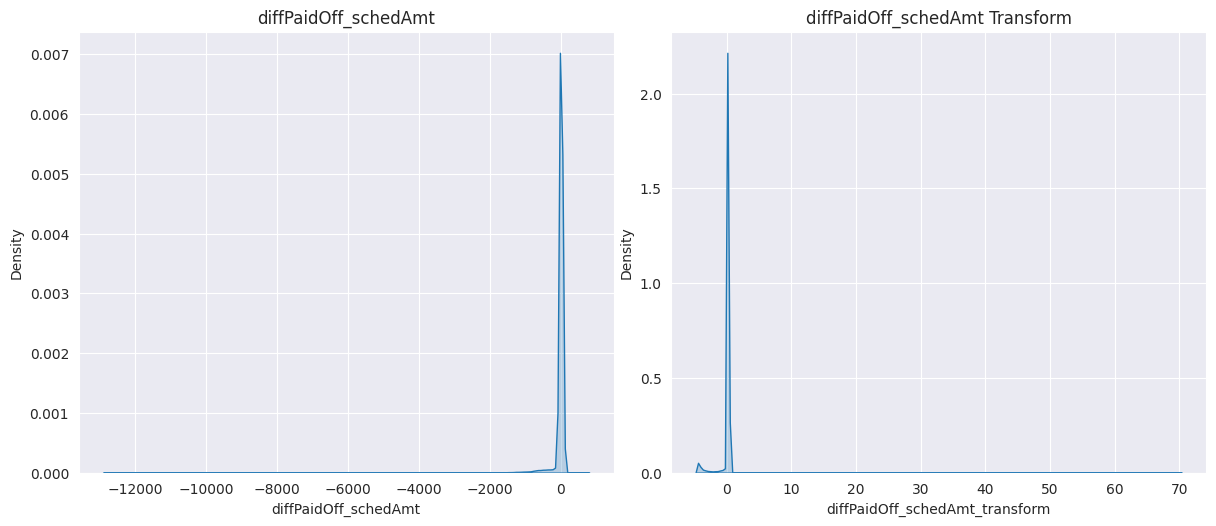

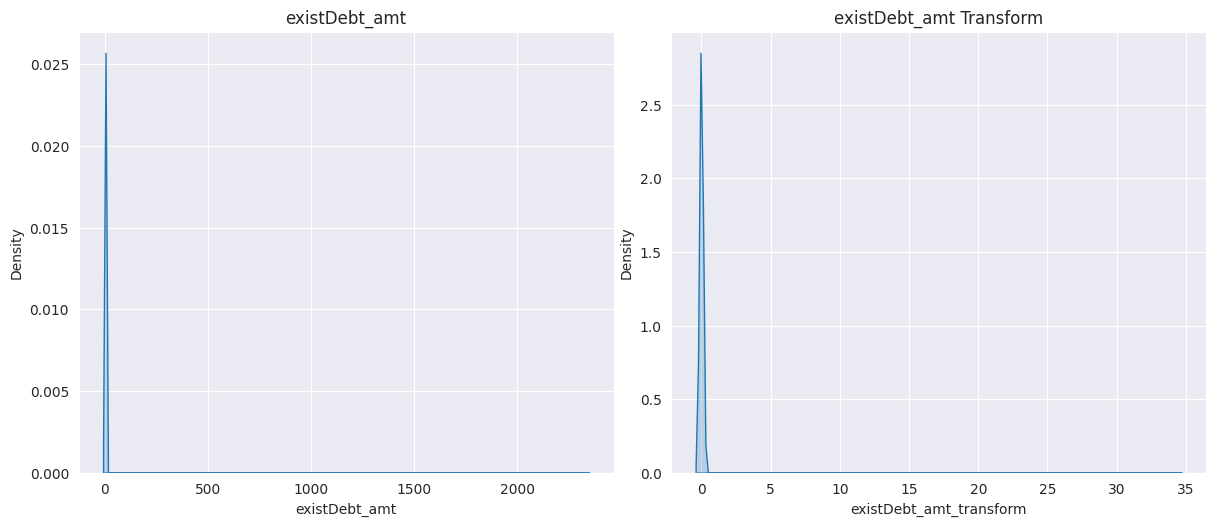

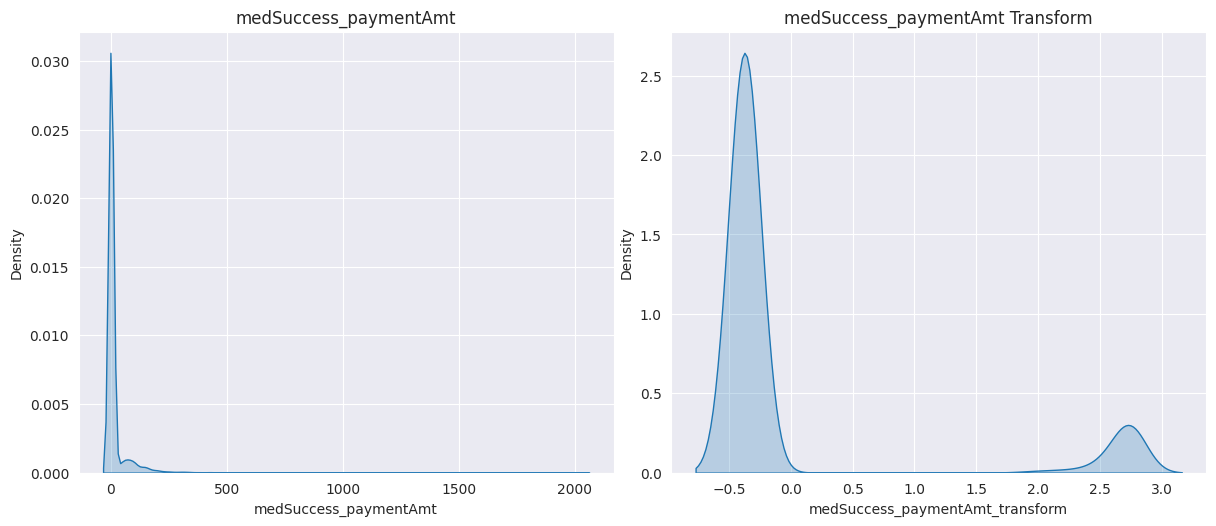

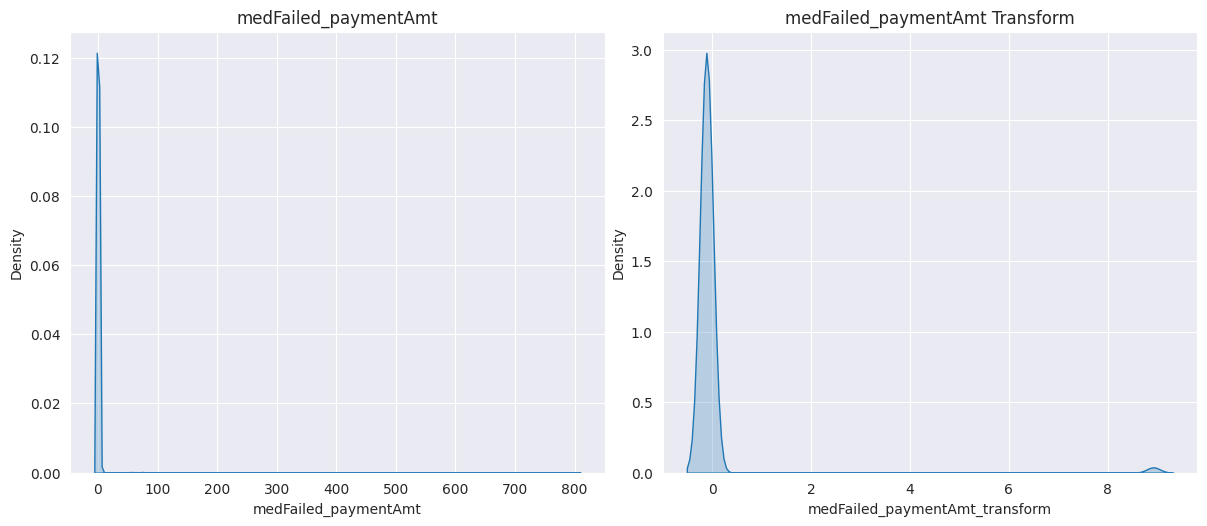

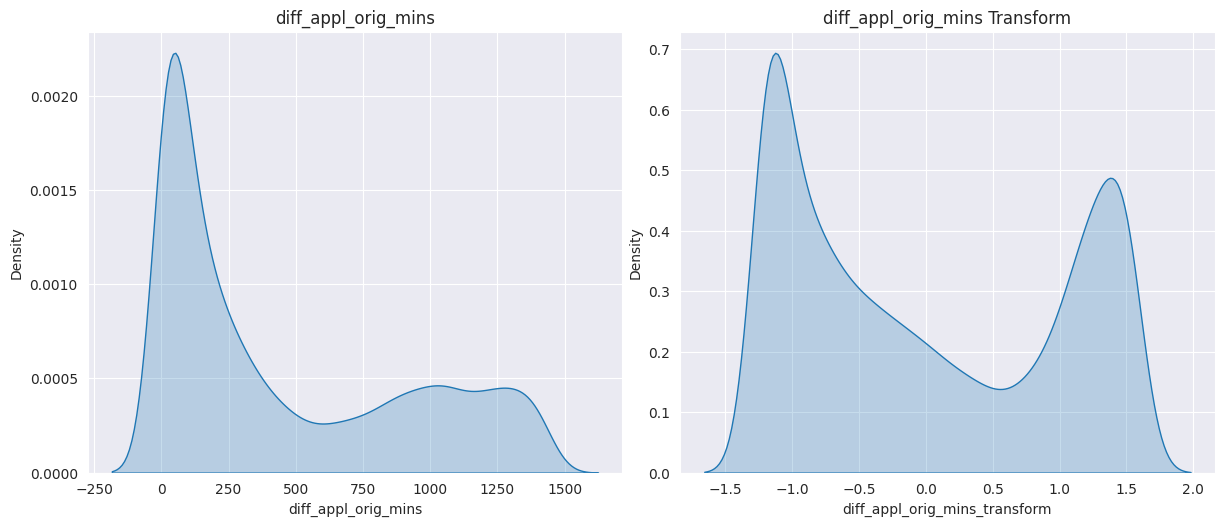

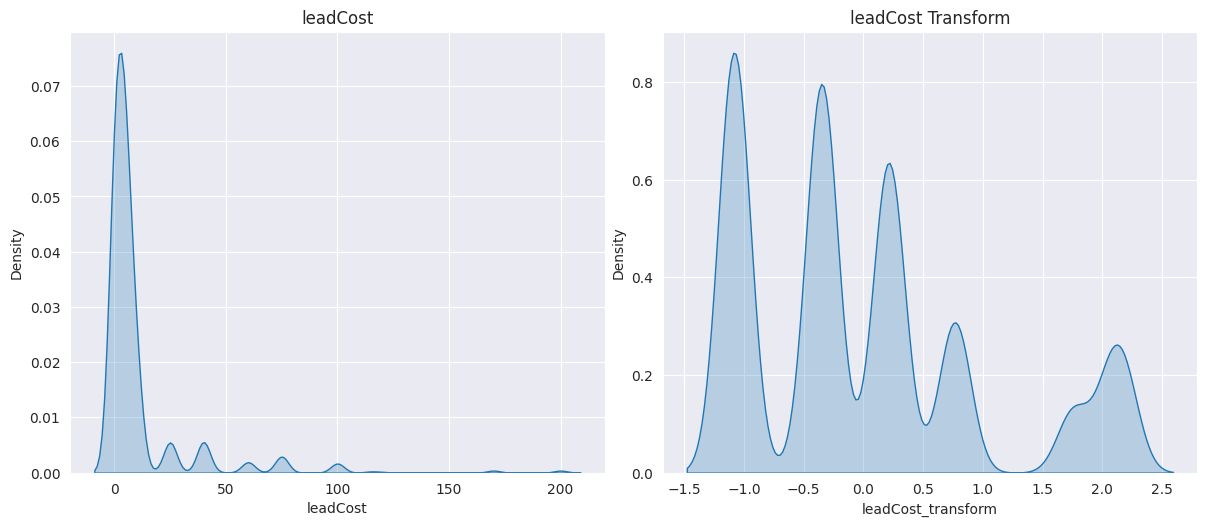

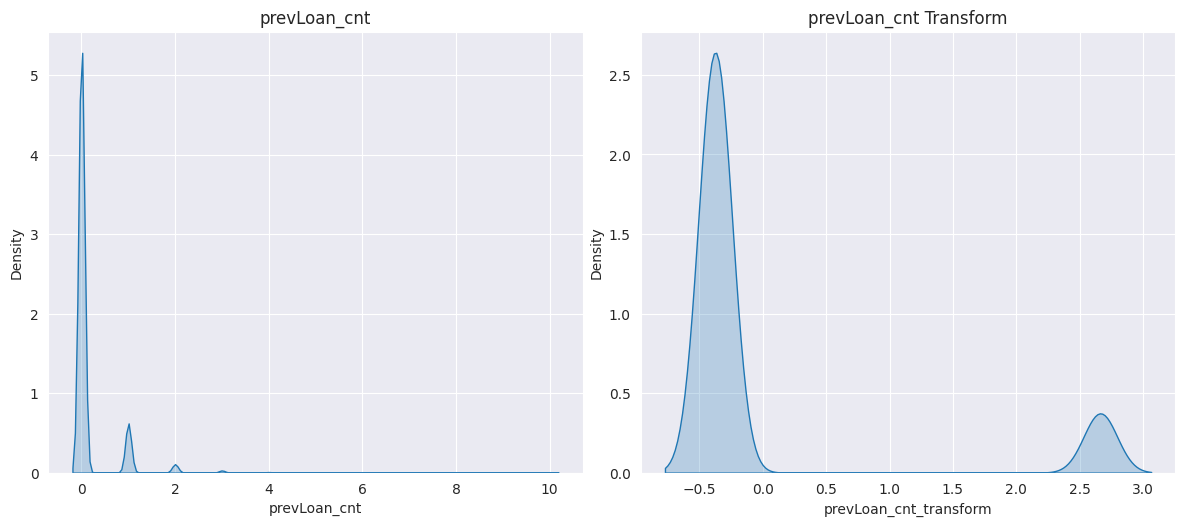

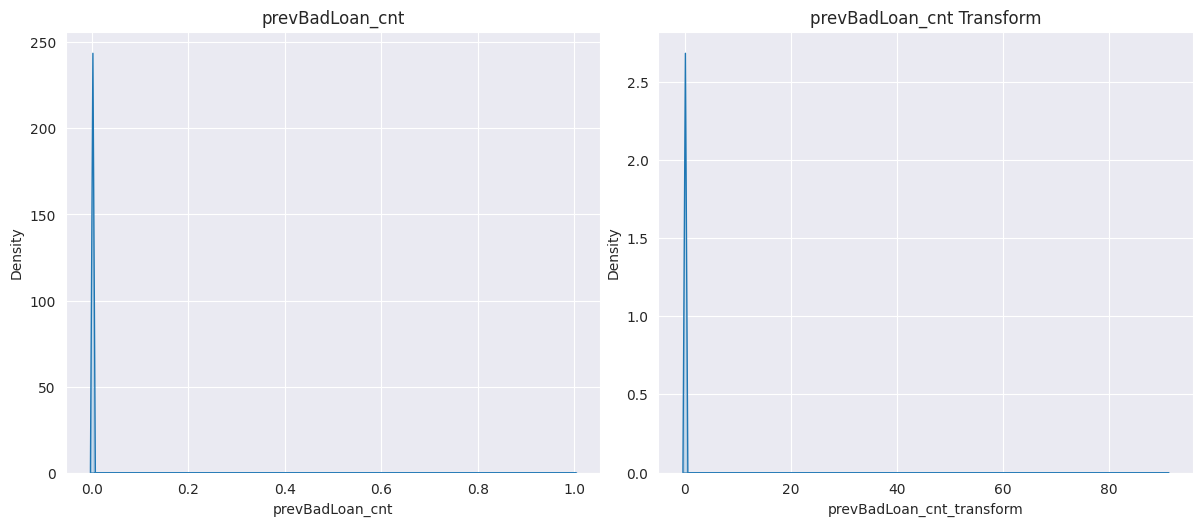

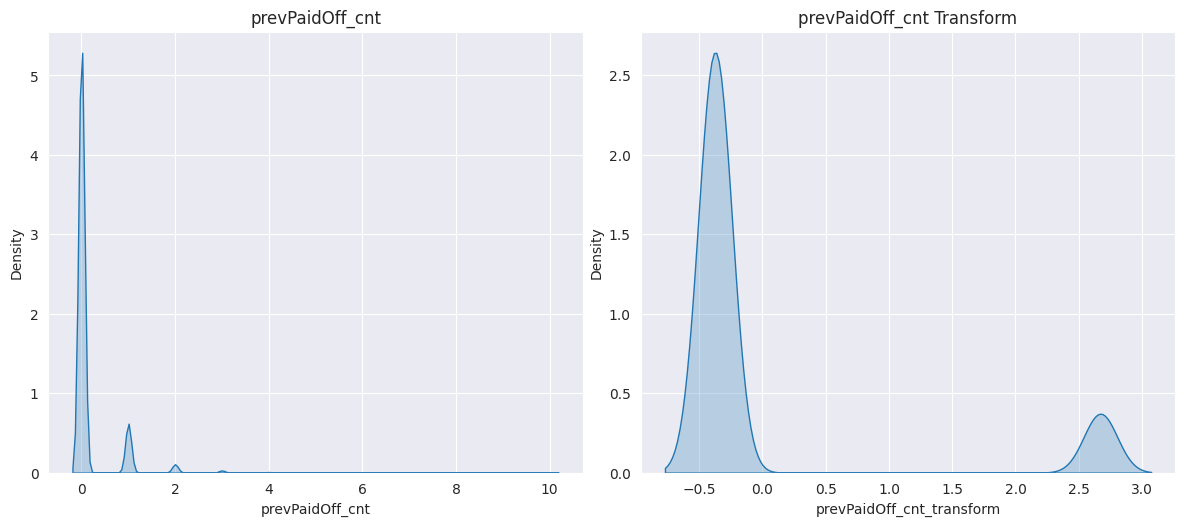

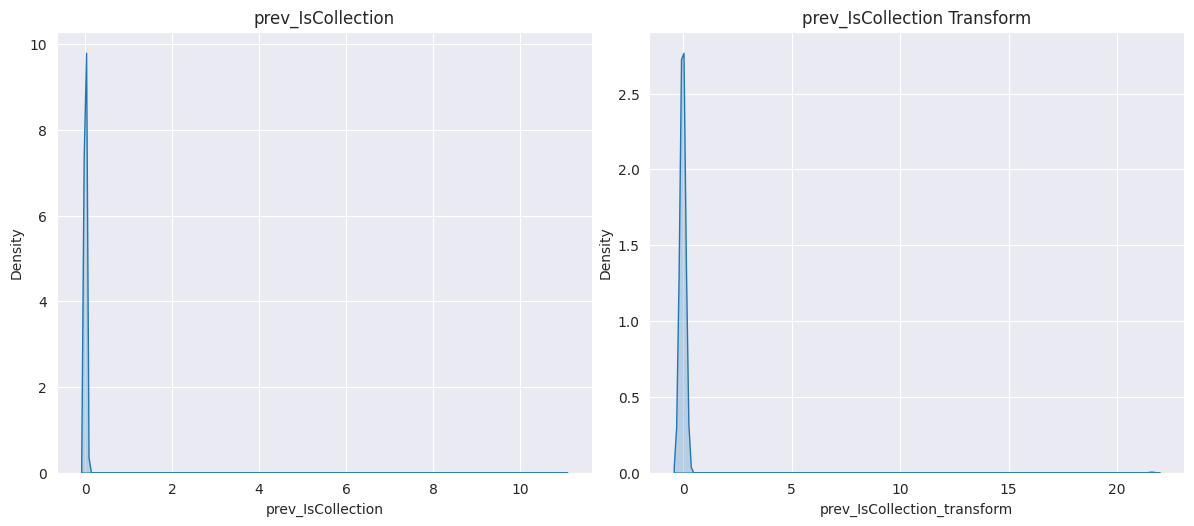

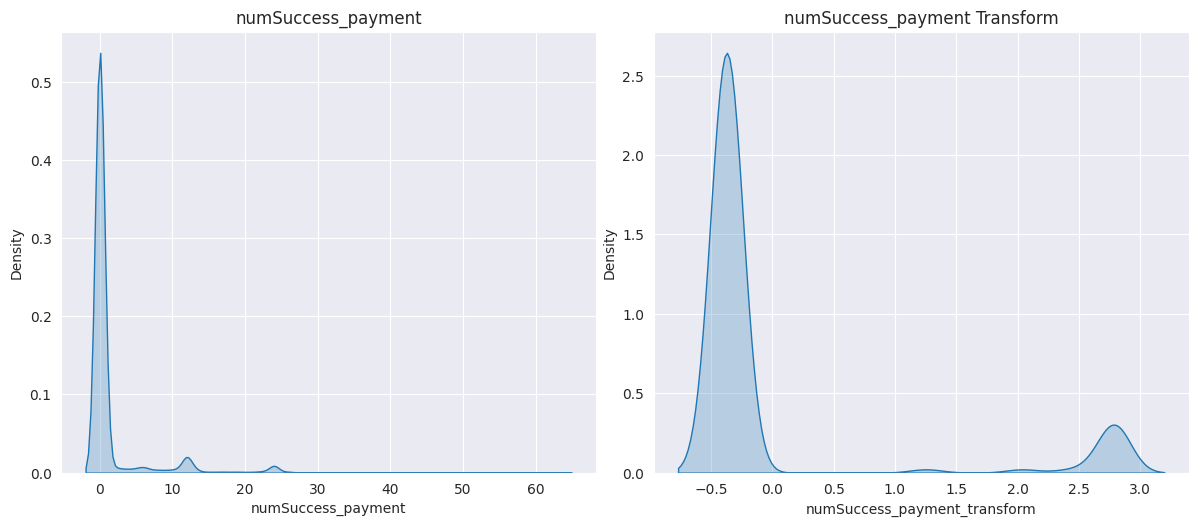

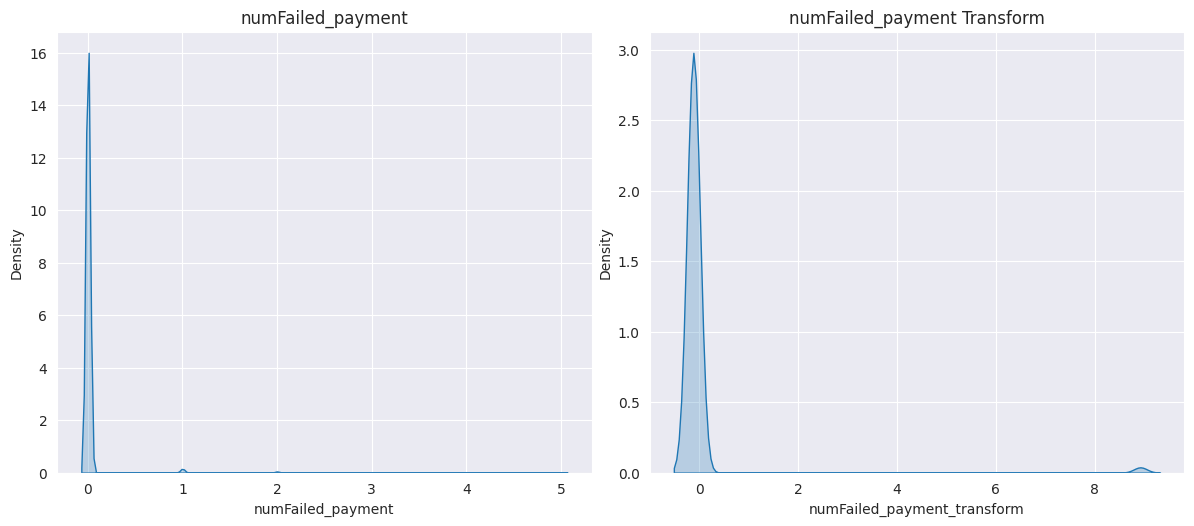

In [ ]:
for col_ in non_normal_num_col:

  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  fig.tight_layout()

  sns.kdeplot(in_time_df[col_],fill=True,ax=ax[0])
  ax[0].set_title(col_)
  sns.kdeplot(scale_df[col_+"_transform"],fill=True,ax=ax[1])
  ax[1].set_title(col_+" Transform")
  plt.show()

In [ ]:
print(in_time_df.shape)
print(out_time_df.shape)

in_time_df = pd.concat([in_time_df,scale_df],axis=1)
out_time_df = pd.concat([out_time_df,scaler_out_df],axis=1)

print("----------- Merged -----------")
print(in_time_df.shape)
print(out_time_df.shape)

(24741, 78)
(4777, 78)
----------- Merged -----------
(24741, 93)
(4777, 93)



1. A new featuer was created which is known as **Failed Success Payment Ratio**, and the way the feature is derived is as follows:

  - $Failed Success Payment Ratio = \frac{Number of Failed Payment}{Number of Success Payment + small value}$
  - where $small value$ is given by $1 x 10^{-17}$

2. Furthermore, feature engineering has also been applied to the columns **inquiryonfilecurrentaddressconflict, morethan3inquiriesinthelast30days, inquirycurrentaddressnotonfile** using the following conditions
  - Replacing True to 1
  - Replacing False to 0
  - Imputing missing values with 0

3. Lastly, feature engineering has also been applied to the columns **overallmatchresult, nameaddressmatch** using the following conditions
  - Replacing invalid to -1
  - Replacing other to -1
  - Replacing unavailable to -1
  - Imputing missing values with -1
  - Replacing mismatch to 0
  - Replacing partial to 0.5
  - Replacing match to 1

In [ ]:
in_time_df['failed_success_payment_ratio'] = in_time_df['numFailed_payment']/(in_time_df['numSuccess_payment'] + smallvalue)

for col_ in ['inquiryonfilecurrentaddressconflict','morethan3inquiriesinthelast30days','inquirycurrentaddressnotonfile']:
  in_time_df[col_] = in_time_df[col_].replace(True,1)
  in_time_df[col_] = in_time_df[col_].replace(False,0)
  in_time_df[col_].fillna(0,inplace=True)

for col_ in ['overallmatchresult','nameaddressmatch']:
  in_time_df[col_] = in_time_df[col_].replace('match',1)
  in_time_df[col_] = in_time_df[col_].replace('unavailable',-1)
  in_time_df[col_] = in_time_df[col_].replace('partial',0.5)
  in_time_df[col_] = in_time_df[col_].replace('mismatch',0)
  in_time_df[col_] = in_time_df[col_].replace('invalid',-1)
  in_time_df[col_] = in_time_df[col_].replace('other',-1)
  in_time_df[col_].fillna(-1,inplace=True)

In [ ]:
out_time_df['failed_success_payment_ratio'] = out_time_df['numFailed_payment']/(out_time_df['numSuccess_payment'] + smallvalue)

for col_ in ['inquiryonfilecurrentaddressconflict','morethan3inquiriesinthelast30days','inquirycurrentaddressnotonfile']:
  out_time_df[col_] = out_time_df[col_].replace(True,1)
  out_time_df[col_] = out_time_df[col_].replace(False,0)
  out_time_df[col_].fillna(0,inplace=True)

for col_ in ['overallmatchresult','nameaddressmatch']:
  out_time_df[col_] = out_time_df[col_].replace('match',1)
  out_time_df[col_] = out_time_df[col_].replace('unavailable',-1)
  out_time_df[col_] = out_time_df[col_].replace('partial',0.5)
  out_time_df[col_] = out_time_df[col_].replace('mismatch',0)
  out_time_df[col_] = out_time_df[col_].replace('invalid',-1)
  out_time_df[col_] = out_time_df[col_].replace('other',-1)
  out_time_df[col_].fillna(-1,inplace=True)

# Exploratory Data Analysis

In [ ]:
# Target
target_col = 'bad_loan'

### original list
derived_col = ['prevLoan_cnt','prevBadLoan_cnt','prevPaidOff_cnt','diffPaidOff_schedAmt','existDebt_amt','prev_IsCollection',
              'numSuccess_payment','numFailed_payment','medSuccess_paymentAmt','medFailed_paymentAmt','failed_success_payment_ratio']

normal_num_col

### Not first loan
non_normal_num_col
transform_col = [i+"_transform" for i in non_normal_num_col]

### First loan
non_normal_num_col_first = [i for i in non_normal_num_col if ('_' not in i) | ('mins' in i)]
transform_col_first = [i+"_transform" for i in non_normal_num_col_first]

unique_col = ['loanId', 'anon_ssn', 'Year_Month', 'applicationDate']

analysis_col = ['loanAmount','originallyScheduledPaymentAmount','leadCost',

                'prevLoan_cnt', 'prevBadLoan_cnt', 'prevPaidOff_cnt','diffPaidOff_schedAmt', 'existDebt_amt',
                'prev_IsCollection','numSuccess_payment', 'numFailed_payment', 'medSuccess_paymentAmt','medFailed_paymentAmt',

                'clearfraudscore', 'diff_appl_orig_mins',
                'AL', 'AZ', 'CA', 'FL', 'IA', 'ID', 'IL', 'IN', 'KY',
                'LA', 'MO', 'MS', 'NC', 'NJ', 'NV', 'OK', 'TN', 'TX', 'WI',
                'bvMandatory', 'express', 'lead', 'lionpay', 'organic', 'prescreen','rc_returning']

Identified that **ssndobreasoncode** has relatively higher number of missing values, and hence is dropped for this analysis.

In [ ]:
in_time_df[clarity_df.drop(columns=['underwritingid']+drop_clarity_cat_col).columns].isnull().sum()

thirtydaysago                           4586
twentyfourhoursago                      4586
oneminuteago                            4586
onehourago                              4586
ninetydaysago                           4586
sevendaysago                            4586
tenminutesago                           4586
fifteendaysago                          4586
threesixtyfivedaysago                   4586
inquiryonfilecurrentaddressconflict        0
totalnumberoffraudindicators            4600
morethan3inquiriesinthelast30days          0
inquirycurrentaddressnotonfile             0
maxnumberofssnswithanybankaccount       4600
nameaddressmatch                           0
overallmatchresult                         0
ssndobreasoncode                       20877
overallmatchreasoncode                  4608
clearfraudscore                         4664
dtype: int64

In [ ]:
in_time_df.drop(columns=['ssndobreasoncode'],inplace=True)
significant_cat_col.remove("ssndobreasoncode")

First loan is defined using following logics:
1. **Previous Loan Count** > 0, is considered as not the first loan
2. **Previous Loan Count** = 0, is considered as first loan

Based on the in-time data sample, it is observed that **21,684 (87.64%)** of the loan application is first loan.

In [ ]:
in_time_df.groupby(['firstloan']).size()

firstloan
0     3057
1    21684
dtype: int64

In [ ]:
in_time_df['firstloan'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')

1    87.64%
0    12.36%
Name: firstloan, dtype: object

Based on the below observations, for both non-Normal and transformed datasets, the heat map shows a different characteristics in first loan vs non-first loan analysis, for example:
1. **Annual Percentage Rate** has higher correlation with the target in first loan data sample as compared to non-first loan data sample
2. **Number of Failed Payment** is in the top 7 features (top 8 for transformed features) that is correlated with target in the non-first loan data sample, however this is not applicable to first loan data sample.

Hence, here is the proposed model building strategy:
1. To use non-linear models such as tree models instead of linear models where the trees is able to split based on the distinctive behaviour of data samples by different categories (Perhaps First loan vs non-first loan).
2. To build separate linear models for first loan and non-first loan. However, we have observed that only **3,057 (~ 12%)** data is capturing the non-first loan. This means that there are insufficient data for the proposal model buiding strategy.

For experimental purposes, linear model such as Logistic Regression will be included in the baseline model performance comparison.

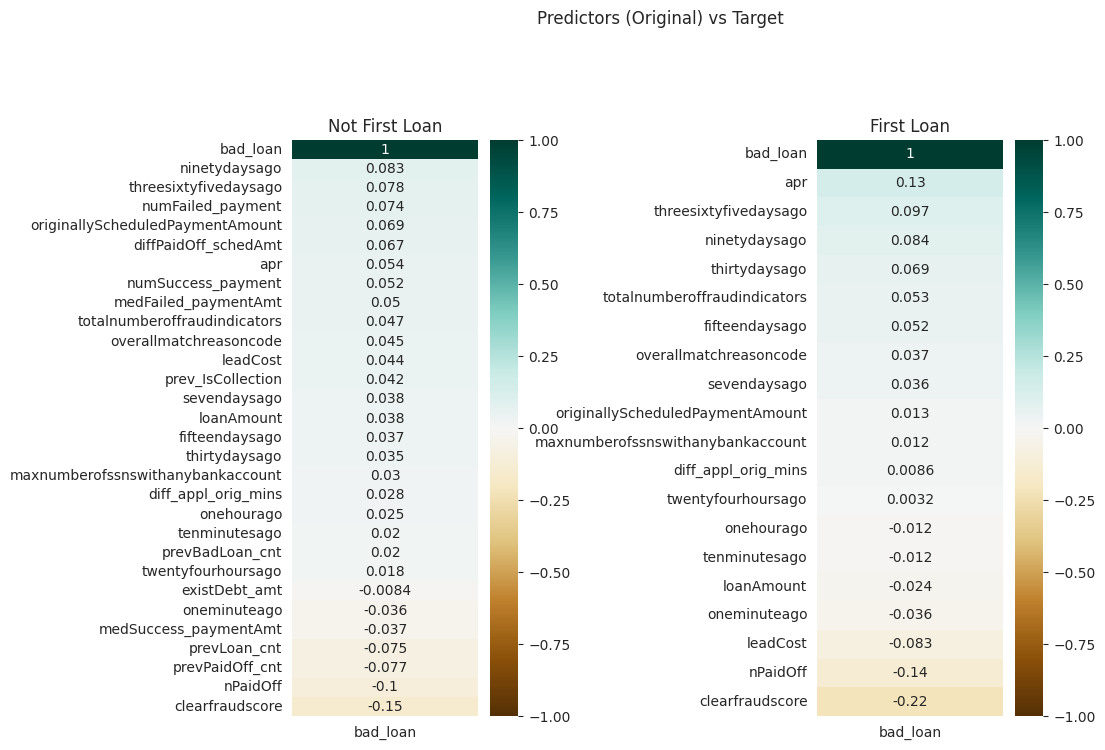

In [ ]:
not_first_loan = in_time_df[in_time_df['firstloan'] == 0][normal_num_col + non_normal_num_col + ['bad_loan']]
first_loan = in_time_df[in_time_df['firstloan'] == 1][normal_num_col + non_normal_num_col_first + ['bad_loan']]

fig, ax = plt.subplots(1, 2, figsize=(13, 10))
fig.tight_layout(pad=18,h_pad=2)

sns.heatmap(not_first_loan.corr()[['bad_loan']].sort_values(by='bad_loan', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax[0])
ax[0].set_title('Not First Loan')
sns.heatmap(first_loan.corr()[['bad_loan']].sort_values(by='bad_loan', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax[1])
ax[1].set_title('First Loan')

fig.suptitle('Predictors (Original) vs Target')
plt.subplots_adjust(top=0.85)

plt.show()

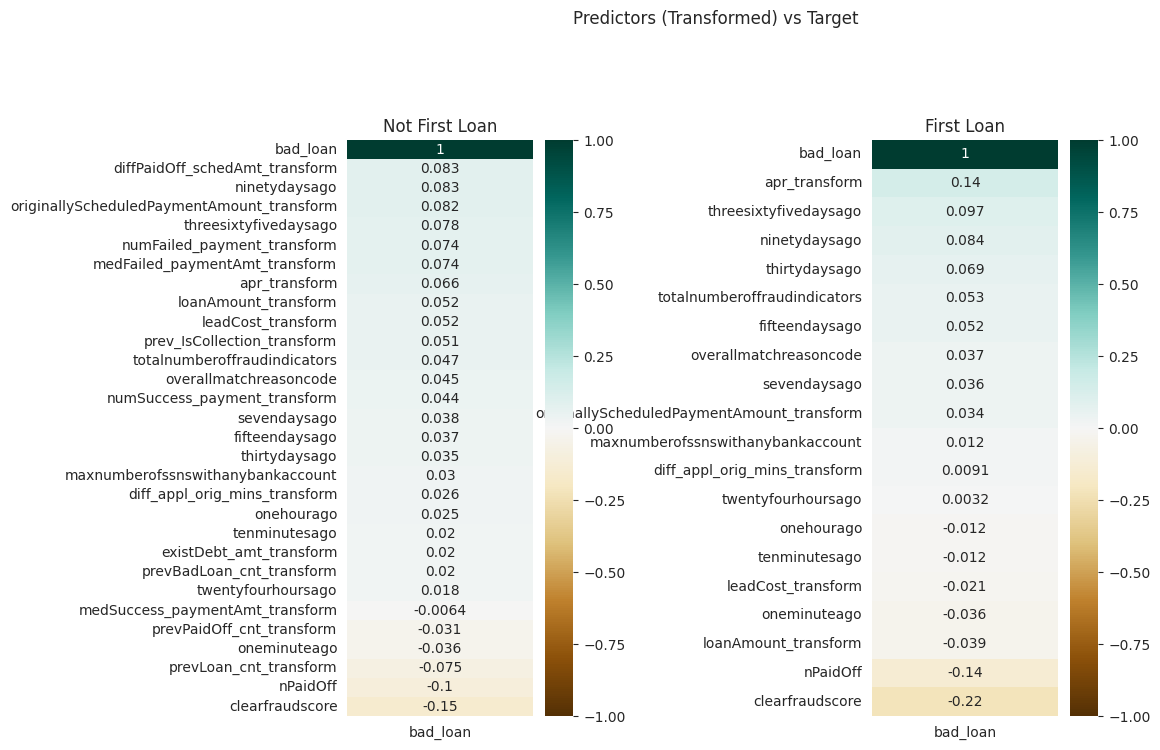

In [ ]:
not_first_loan = in_time_df[in_time_df['firstloan'] == 0][normal_num_col + transform_col + ['bad_loan']]
first_loan = in_time_df[in_time_df['firstloan'] == 1][normal_num_col + transform_col_first + ['bad_loan']]

fig, ax = plt.subplots(1, 2, figsize=(13, 10))
fig.tight_layout(pad=18,h_pad=2)

sns.heatmap(not_first_loan.corr()[['bad_loan']].sort_values(by='bad_loan', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax[0])
ax[0].set_title('Not First Loan')
sns.heatmap(first_loan.corr()[['bad_loan']].sort_values(by='bad_loan', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax[1])
ax[1].set_title('First Loan')

fig.suptitle('Predictors (Transformed) vs Target')
plt.subplots_adjust(top=0.85)

plt.show()

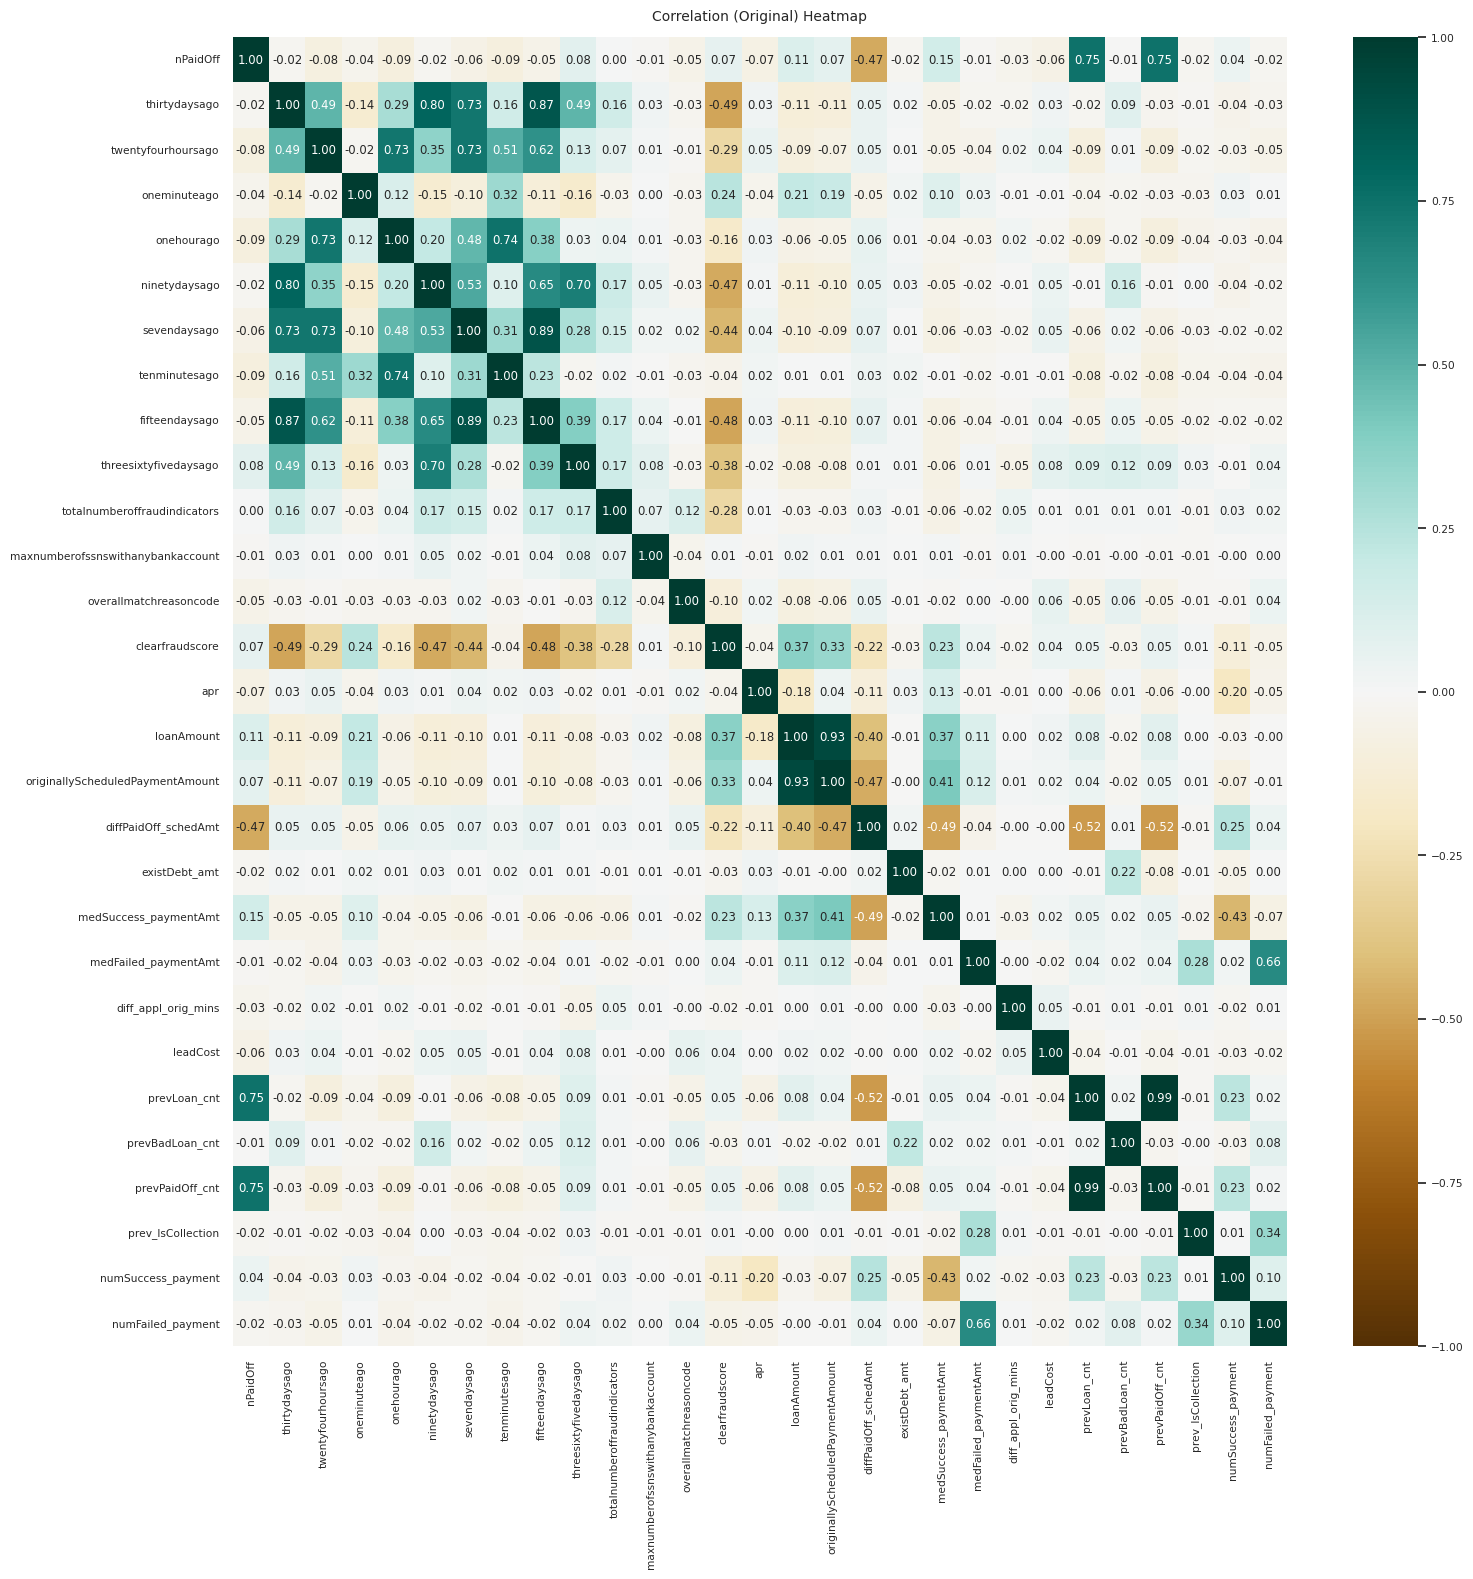

In [ ]:
plt.figure(figsize=(17, 17))
sns.set(font_scale=0.7)
# define the mask to set the values in the upper triangle to True

table = in_time_df[in_time_df['firstloan'] == 0][normal_num_col + non_normal_num_col]

heatmap = sns.heatmap(table.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt='.2f')
heatmap.set_title('Correlation (Original) Heatmap', fontdict={'fontsize':10}, pad=12)
plt.show()

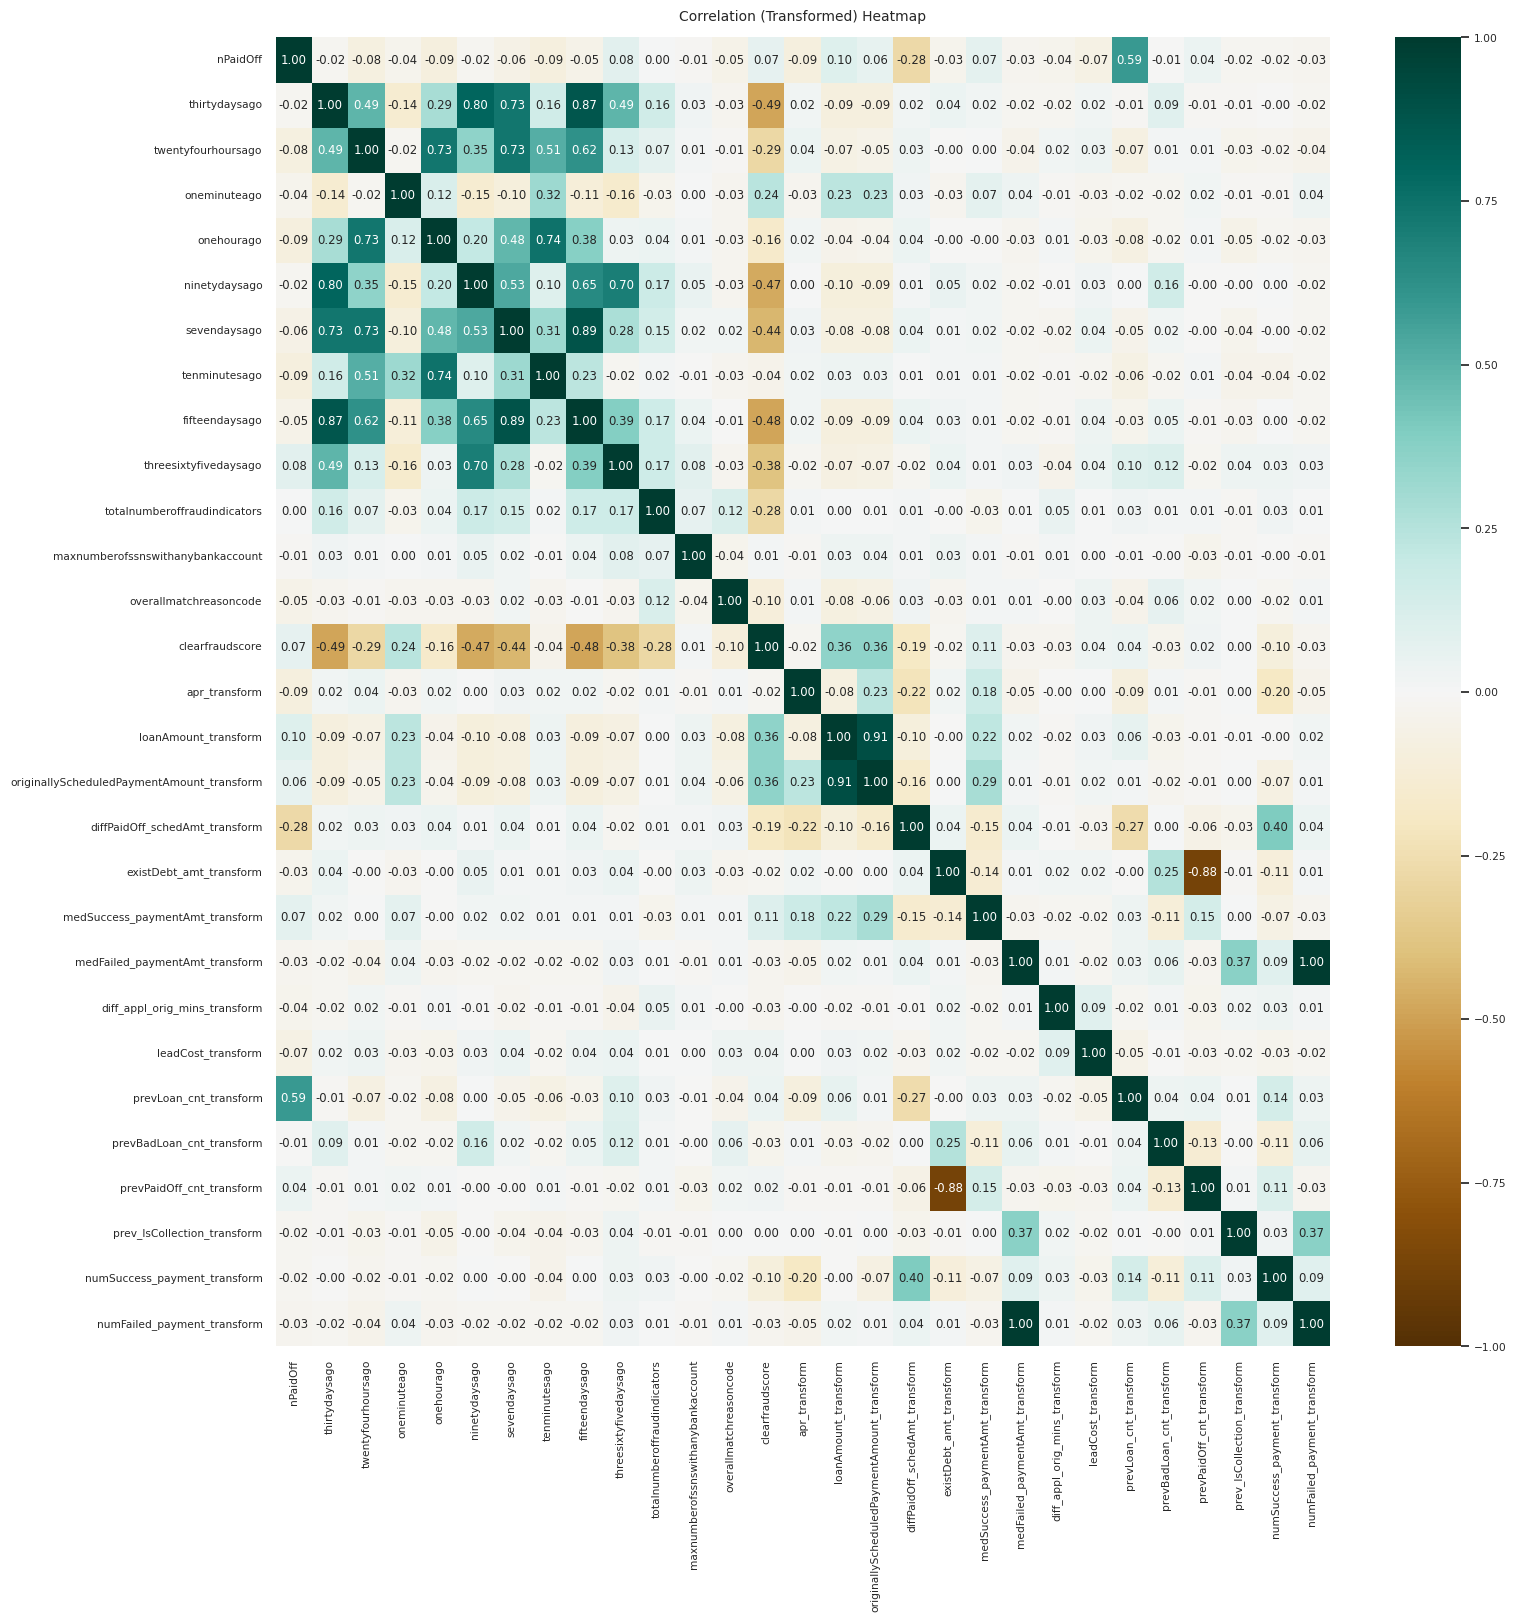

In [ ]:
plt.figure(figsize=(17, 17))
sns.set(font_scale=0.7)
# define the mask to set the values in the upper triangle to True

table = in_time_df[in_time_df['firstloan'] == 0][normal_num_col + transform_col]

heatmap = sns.heatmap(table.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt='.2f')
heatmap.set_title('Correlation (Transformed) Heatmap', fontdict={'fontsize':10}, pad=12)
plt.show()

In [ ]:
table = in_time_df[in_time_df['firstloan'] == 0][normal_num_col + non_normal_num_col]

correlation_table = (
    table.corr().where(
        np.triu(np.ones(table.corr().shape), k=0)
        .astype(bool)
    )
    .stack()
    .to_frame(name='correlation (Original)')
).reset_index()

correlation_table[(correlation_table['correlation (Original)'].abs() >= 0.8) & (correlation_table['correlation (Original)'].abs() < 1)]

level_0                           level_1  correlation (Original)
33   thirtydaysago                     ninetydaysago                0.802316
36   thirtydaysago                    fifteendaysago                0.869999
161   sevendaysago                    fifteendaysago                0.885578
331     loanAmount  originallyScheduledPaymentAmount                0.932922
416   prevLoan_cnt                   prevPaidOff_cnt                0.992360

In [ ]:
table = in_time_df[in_time_df['firstloan'] == 0][normal_num_col + transform_col]

correlation_table = (
    table.corr().where(
        np.triu(np.ones(table.corr().shape), k=0)
        .astype(bool)
    )
    .stack()
    .to_frame(name='correlation (Transformed)')
).reset_index()

correlation_table[(correlation_table['correlation (Transformed)'].abs() >= 0.8) & (correlation_table['correlation (Transformed)'].abs() < 1)]

level_0  \
33                    thirtydaysago   
36                    thirtydaysago   
161                    sevendaysago   
331            loanAmount_transform   
376         existDebt_amt_transform   
398  medFailed_paymentAmt_transform   

                                        level_1  correlation (Transformed)  
33                                ninetydaysago                   0.802316  
36                               fifteendaysago                   0.869999  
161                              fifteendaysago                   0.885578  
331  originallyScheduledPaymentAmount_transform                   0.910899  
376                   prevPaidOff_cnt_transform                  -0.875509  
398                 numFailed_payment_transform                   0.999999

In [ ]:
table = in_time_df[normal_num_col + non_normal_num_col_first]

correlation_table = (
    table.corr().where(
        np.triu(np.ones(table.corr().shape), k=0)
        .astype(bool)
    )
    .stack()
    .to_frame(name='correlation (Original, removed derived features')
).reset_index()

correlation_table[(correlation_table['correlation (Original, removed derived features'].abs() >= 0.8) & (correlation_table['correlation (Original, removed derived features'].abs() < 1)]

level_0                           level_1  \
26   thirtydaysago                    fifteendaysago   
101   sevendaysago                    fifteendaysago   
181     loanAmount  originallyScheduledPaymentAmount   

     correlation (Original, removed derived features  
26                                          0.866266  
101                                         0.870926  
181                                         0.948468

In [ ]:
table = in_time_df[normal_num_col + transform_col_first]

correlation_table = (
    table.corr().where(
        np.triu(np.ones(table.corr().shape), k=0)
        .astype(bool)
    )
    .stack()
    .to_frame(name='correlation (Transformed, removed derived features')
).reset_index()

correlation_table[(correlation_table['correlation (Transformed, removed derived features'].abs() >= 0.8) & (correlation_table['correlation (Transformed, removed derived features'].abs() < 1)]

level_0                                     level_1  \
26          thirtydaysago                              fifteendaysago   
101          sevendaysago                              fifteendaysago   
181  loanAmount_transform  originallyScheduledPaymentAmount_transform   

     correlation (Transformed, removed derived features  
26                                            0.866266   
101                                           0.870926   
181                                           0.915783

From the above correlation matrix analysis based on different scenarios, the common findings are

1. thirtydaysago is $+ve$ correlated to ninetydaysago and fifteendaysago
2. fifteendaysago is $+ve$ correlated to thirtydaysago and sevendaysago
3. loanAmount is $+ve$ correlated to originallyScheduledPaymentAmount, apply to before transformed and after transformed

For cases where loan application is not the first loan, the findings are

**Before Transform :**
1. Previous loan count is $+ve$ correlated to Previous paid off loan count

**After Transform :**
1. Existing loan debt amount (RM) is $-ve$ correlated to Previous paid off loan count
2. Median of Failed Payment Amount (RM) is $+ve$ correlated to Number of Failed payment


In the next section, we will have to remove highly correlated predictors to prevent multicollinearity for model building, using the following approach:
1. For Baseline Models Comparison, **Logistic Regression, Support Vector Classifier, Random Forest Classifier, Gradient Boosting Classifier and XGBoost Classifier** are tested. Due to multiple types of algorithms are tested, highly correlated features are removed using VIF test in iterative way, until VIF < 5 is achieved.
2. For tree models, highly correlated features are replaced iteratively and trained with **Random Forest Classifier** as a default model, the test dataset model performances are recorded. Using **f1-score** as a performance metric, features that yield higher **f1-score** will be kept as required feature input, and respective correlated metric will be removed as feature input.


# Model Experiments

In model building section, we will be comparing different models approach before deciding on the best model, such as:
1. Model trained using **non-Normal dataset** vs **Transformed dataset**
2. Baseline models with default parameters, comparing using **Logistic Regression, Support Vector Classifier, Random Forest Classifier, Gradient Boosting Classifier and XGBoost Classifier**
3. Optimized models after hyperparameter tuning, comparing using **Random Forest Classifier and Gradient Boosting Classifier**

In [ ]:
X_col_raw = normal_num_col+non_normal_num_col+significant_cat_col+['payFrequency']
X_col_transformed = normal_num_col+transform_col+significant_cat_col+['payFrequency']

multi_corr = ['thirtydaysago','ninetydaysago','fifteendaysago','sevendaysago']
multi_corr_raw = ['prevLoan_cnt','prevPaidOff_cnt','loanAmount','originallyScheduledPaymentAmount']
multi_corr_transformed = ['loanAmount_transform','originallyScheduledPaymentAmount_transform',
                          'existDebt_amt_transform','prevPaidOff_cnt_transform',
                          'medFailed_paymentAmt_transform','numFailed_payment_transform']

In [ ]:
final_min_max_col = normal_num_col+non_normal_num_col+transform_col+significant_cat_col+['payFrequency']

in_time_df = in_time_df.reset_index(drop=True)
out_time_df = out_time_df.reset_index(drop=True)

# in time
minmax_scaler_final = MinMaxScaler()
minmax_scaler_final.fit(in_time_df[final_min_max_col])
in_time_minmax_df = pd.DataFrame(minmax_scaler_final.transform(in_time_df[final_min_max_col]),columns=final_min_max_col)

# fit out time
out_time_minmax_df = pd.DataFrame(minmax_scaler_final.transform(out_time_df[final_min_max_col]),columns=final_min_max_col)
out_time_minmax_df.clip(upper=1,inplace=True)
out_time_minmax_df.clip(lower=0,inplace=True)

print(in_time_df.shape)
print(out_time_df.shape)

in_time_minmax_df['loanId'] = in_time_df['loanId']
out_time_minmax_df['loanId'] = out_time_df['loanId']

in_time_minmax_df['bad_loan'] = in_time_df['bad_loan']
out_time_minmax_df['bad_loan'] = out_time_df['bad_loan']

print("")
print(in_time_minmax_df.shape)
print(out_time_minmax_df.shape)

(24741, 93)
(4777, 94)

(24741, 78)
(4777, 78)


In [ ]:
in_time_df2 = in_time_minmax_df.dropna(how='any').reset_index(drop=True)
out_time_df2 = out_time_minmax_df.dropna(how='any').reset_index(drop=True)

In [ ]:
X_in_time = in_time_df2.drop(columns=[target_col]).reset_index(drop=True)
y_in_time = in_time_df2[target_col].reset_index(drop=True)

X_out_time = out_time_df2.drop(columns=[target_col]).reset_index(drop=True)
y_out_time = out_time_df2[target_col].reset_index(drop=True)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_in_time, y_in_time, test_size=0.2, random_state=0)

## Baseline Models Comparison

For Baseline Models Comparison, **Logistic Regression, Support Vector Classifier, Random Forest Classifier, Gradient Boosting Classifier and XGBoost Classifier** are tested. Due to multiple types of algorithms are tested, highly correlated features are removed using VIF test in iterative way, until VIF < 5 is achieved.

### non-Normal dataset

In [ ]:
# features to consider removing
considered_features_raw = X_col_raw.copy()
df_raw = X_train[considered_features_raw].copy()

remove_multicollinearity_vif(df_raw, considered_features_raw)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['prevLoan_cnt'] [346.26]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['bvMandatory'] [167.44]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['loanAmount'] [23.61]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['fifteendaysago'] [7.89]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['prevPaidOff_cnt'] [7.68]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Based on the VIF result, **Previous Loan Count, By Mandatory Flag, Loan Amount, Number of unique inquiries for the consumer seen by Clarity in the last 15 days, and Previous Paid Off Loan Count** are dropped as feature inputs.

In [ ]:
model_list = []
f1_list = []
prec_list = []
recall_list = []
auc_list = []

f1_out_list = []
prec_out_list = []
recall_out_list = []
auc_out_list = []

models = {'Logistic Regression': LogisticRegression(max_iter=1000,
                                                    n_jobs=-1,
                                                    random_state=11),
          'Support Vector Machine': SVC(probability=True,
                                        random_state=11),
          'Random Forest Classifier': RandomForestClassifier(n_jobs=-1,
                                                           random_state=11),
          'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=11),
          'XGBoost Classifier': xgb.XGBClassifier(objective="binary:logistic", random_state=11)
          }
for name, model in models.items():

  X_train_temp = X_train[considered_features_raw]
  y_train_temp = y_train

  X_test_temp = X_test[considered_features_raw]
  y_test_temp = y_test

  model.fit(X_train_temp, y_train_temp)

  y_pred = model.predict(X_test_temp)
  y_pred_out = model.predict(X_out_time[considered_features_raw])

  f1 = f1_score(y_test_temp, y_pred)
  prec = precision_score(y_test_temp, y_pred)
  recall = recall_score(y_test_temp, y_pred)
  auc = roc_auc_score(y_test_temp, y_pred)

  f1_out = f1_score(y_out_time, y_pred_out)
  prec_out = precision_score(y_out_time, y_pred_out)
  recall_out = recall_score(y_out_time,y_pred_out)
  auc_out = roc_auc_score(y_out_time, y_pred_out)

  model_list.append(name)
  f1_list.append(f1)
  prec_list.append(prec)
  recall_list.append(recall)
  auc_list.append(auc)

  f1_out_list.append(f1_out)
  prec_out_list.append(prec_out)
  recall_out_list.append(recall_out)
  auc_out_list.append(auc_out)

In [ ]:
baseline_model_perf = pd.DataFrame(zip(model_list,f1_list,prec_list,recall_list,auc_list,f1_out_list,prec_out_list,recall_out_list,auc_out_list),
                                  columns=['model','f1','precision','recall','auc','f1_out','precision_out','recall_out','auc_out']).round(3).T

baseline_model_perf.rename(columns=baseline_model_perf.iloc[0]).drop(baseline_model_perf.index[0])

Logistic Regression Support Vector Machine  \
f1                           0.72                  0.699   
precision                   0.668                  0.655   
recall                       0.78                  0.749   
auc                          0.63                   0.61   
f1_out                      0.833                  0.836   
precision_out               0.797                  0.797   
recall_out                  0.874                  0.879   
auc_out                     0.581                  0.583   

              Random Forest Classifier Gradient Boosting Classifier  \
f1                               0.709                        0.723   
precision                        0.675                        0.673   
recall                           0.746                         0.78   
auc                              0.632                        0.636   
f1_out                            0.84                        0.834   
precision_out                    0.808                        0.798   
recall_out                       0.873                        0.873   
auc_out                          0.607                        0.585   

              XGBoost Classifier  
f1                         0.712  
precision                  0.673  
recall                     0.755  
auc                        0.631  
f1_out                     0.836  
precision_out              0.803  
recall_out                 0.871  
auc_out                    0.596

### Transformed dataset

In [ ]:
# features to consider removing
considered_features_transformed = X_col_transformed.copy()
df_transformed = X_train[considered_features_transformed].copy()

remove_multicollinearity_vif(df_transformed, considered_features_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['medFailed_paymentAmt_transform'] [146815.97]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['prevLoan_cnt_transform'] [784.39]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['prevPaidOff_cnt_transform'] [172.26]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['bvMandatory'] [130.08]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['medSuccess_paymentAmt_transform'] [49.23]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['originallyScheduledPaymentAmount_transform'] [29.65]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


=========================== Remove High VIF Variables ===========================

['fifteendaysago'] [7.89]



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Based on the VIF result, **median Failed Payment Amount (Transformed), Previous Loan Count (Transformed), Previous Paid Off Loan Count (Transformed), By Mandatory Flag, median Success Payment Amount (Transformed), Originally Scheduled Payment Amount (Transformed), and  Number of unique inquiries for the consumer seen by Clarity in the last 15 days** are dropped as feature inputs.

In [ ]:
model_list = []
f1_list = []
prec_list = []
recall_list = []
auc_list = []

f1_out_list = []
prec_out_list = []
recall_out_list = []
auc_out_list = []

models = {'Logistic Regression': LogisticRegression(max_iter=1000,
                                                    n_jobs=-1,
                                                    random_state=11),
          'Support Vector Machine': SVC(probability=True,
                                        random_state=11),
          'Random Forest Classifier': RandomForestClassifier(n_jobs=-1,
                                                           random_state=11),
          'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=11),
          'XGBoost Classifier': xgb.XGBClassifier(objective="binary:logistic", random_state=11)
          }
for name, model in models.items():

  X_train_temp = X_train[considered_features_transformed]
  y_train_temp = y_train

  X_test_temp = X_test[considered_features_transformed]
  y_test_temp = y_test

  model.fit(X_train_temp, y_train_temp)

  y_pred = model.predict(X_test_temp)
  y_pred_out = model.predict(X_out_time[considered_features_transformed])

  f1 = f1_score(y_test_temp, y_pred)
  prec = precision_score(y_test_temp, y_pred)
  recall = recall_score(y_test_temp, y_pred)
  auc = roc_auc_score(y_test_temp, y_pred)

  f1_out = f1_score(y_out_time, y_pred_out)
  prec_out = precision_score(y_out_time, y_pred_out)
  recall_out = recall_score(y_out_time,y_pred_out)
  auc_out = roc_auc_score(y_out_time, y_pred_out)

  model_list.append(name)
  f1_list.append(f1)
  prec_list.append(prec)
  recall_list.append(recall)
  auc_list.append(auc)

  f1_out_list.append(f1_out)
  prec_out_list.append(prec_out)
  recall_out_list.append(recall_out)
  auc_out_list.append(auc_out)

In [ ]:
baseline_model_perf = pd.DataFrame(zip(model_list,f1_list,prec_list,recall_list,auc_list,f1_out_list,prec_out_list,recall_out_list,auc_out_list),
                                  columns=['model','f1','precision','recall','auc','f1_out','precision_out','recall_out','auc_out']).round(3).T

baseline_model_perf.rename(columns=baseline_model_perf.iloc[0]).drop(baseline_model_perf.index[0])

Logistic Regression Support Vector Machine  \
f1                          0.719                  0.705   
precision                    0.67                  0.657   
recall                      0.777                   0.76   
auc                         0.631                  0.614   
f1_out                      0.836                  0.832   
precision_out               0.801                  0.798   
recall_out                  0.874                  0.869   
auc_out                      0.59                  0.583   

              Random Forest Classifier Gradient Boosting Classifier  \
f1                               0.713                        0.729   
precision                        0.676                        0.677   
recall                           0.755                        0.791   
auc                              0.634                        0.642   
f1_out                           0.838                        0.841   
precision_out                    0.808                        0.802   
recall_out                        0.87                        0.884   
auc_out                          0.606                        0.594   

              XGBoost Classifier  
f1                         0.704  
precision                  0.667  
recall                     0.745  
auc                        0.622  
f1_out                     0.838  
precision_out              0.806  
recall_out                 0.872  
auc_out                    0.602

Based on the model experiments above, the findings are as such:

Both **Random Forest Classifier and Gradient Boosting Classifier** have higher recall and AUC in the in-time test dataset

1. non-Normal dataset
    1. Gradient Boosting Classifier(0.78 Recall, 0.636 AUC)
    2. Random Forest Classifier(0.746 Recall, 0.632 AUC)
2. Transformed dataset
    1. Gradient Boosting Classifier(0.791 Recall, 0.642 AUC)
    2. Random Forest Classifier(0.755 Recall, 0.634 AUC)

Additonally, **Random Forest Classifier** has the highest AUC in out-time validation dataset for both non-Normal and Transformed model experiments.

## Random Forest Classifier
For tree models, highly correlated features are replaced iteratively and trained with **Random Forest Classifier** as a default model, the test dataset model performances are recorded. Using **f1-score** as a performance metric, features that yield higher **f1-score** will be kept as required feature input, and respective correlated metric will be removed as feature input.

### non-Normal dataset

In [ ]:
multi_col_list = []
f1_list = []
prec_list = []
recall_list = []
auc_list = []

for new_ in multi_corr+multi_corr_raw:
  X_col_temp = [i for i in X_col_raw if i not in multi_corr+multi_corr_raw]+[new_]

  X_train_temp = X_train[X_col_temp]
  y_train_temp = y_train

  X_test_temp = X_test[X_col_temp]
  y_test_temp = y_test

  rf = RandomForestClassifier(n_jobs=-1,random_state=11)
  rf.fit(X_train_temp,y_train_temp)

  y_pred = rf.predict(X_test_temp)

  f1 = f1_score(y_test_temp, y_pred)
  prec = precision_score(y_test_temp, y_pred)
  recall = recall_score(y_test_temp, y_pred)
  auc = roc_auc_score(y_test_temp, y_pred)

  multi_col_list.append(new_)
  f1_list.append(f1)
  prec_list.append(prec)
  recall_list.append(recall)
  auc_list.append(auc)

In [ ]:
pd.DataFrame(zip(multi_col_list,f1_list,prec_list,recall_list,auc_list),columns=['Variable','f1','precision','recall','auc']).sort_values(['f1'],ascending=False)

Variable        f1  precision    recall       auc
7  originallyScheduledPaymentAmount  0.710037   0.676772  0.746742  0.633733
5                   prevPaidOff_cnt  0.702893   0.670213  0.738923  0.625153
3                      sevendaysago  0.702189   0.669291  0.738488  0.624060
0                     thirtydaysago  0.702066   0.669425  0.738054  0.624135
1                     ninetydaysago  0.701390   0.671434  0.734144  0.625683
6                        loanAmount  0.701138   0.669167  0.736316  0.623558
2                    fifteendaysago  0.698195   0.668122  0.731103  0.621535
4                      prevLoan_cnt  0.696876   0.665350  0.731538  0.618542

Based on the model result, **Originally Scheduled Payment Amount, Number of unique inquiries for the consumer seen by Clarity in the last 90 days, Previous Paid Off Loan Count, and Number of unique inquiries for the consumer seen by Clarity in the last 7 days** are used as feature inputs.

In [ ]:
X_col_temp = [i for i in X_col_raw if i not in multi_corr+multi_corr_raw]+['originallyScheduledPaymentAmount','ninetydaysago','prevPaidOff_cnt','sevendaysago']

X_train_temp = X_train[X_col_temp]
y_train_temp = y_train

X_test_temp = X_test[X_col_temp]
y_test_temp = y_test

rf = RandomForestClassifier(n_jobs=-1,random_state=11)
rf.fit(X_train_temp,y_train_temp)

y_pred = rf.predict(X_test_temp)

f1 = f1_score(y_test_temp, y_pred)
prec = precision_score(y_test_temp, y_pred)
recall = recall_score(y_test_temp, y_pred)
auc = roc_auc_score(y_test_temp, y_pred)

In [ ]:
print(f1)
print(prec)
print(recall)
print(auc)

0.7104231166150672
0.6767597325992922
0.7476107732406603
0.6338754391597345


In [ ]:
y_pred_out = rf.predict(X_out_time[X_col_temp])

f1 = f1_score(y_out_time, y_pred_out)
prec = precision_score(y_out_time, y_pred_out)
recall = recall_score(y_out_time,y_pred_out)
auc = roc_auc_score(y_out_time, y_pred_out)

print(f1)
print(prec)
print(recall)
print(auc)

0.8436363636363637
0.8093776165224672
0.8809234507897934
0.6098712123261649


### Transformed dataset

In [ ]:
multi_col_list = []
f1_list = []
prec_list = []
recall_list = []
auc_list = []

for new_ in multi_corr+multi_corr_transformed:
  X_col_temp = [i for i in X_col_transformed if i not in multi_corr+multi_corr_transformed]+[new_]

  X_train_temp = X_train[X_col_temp]
  y_train_temp = y_train

  X_test_temp = X_test[X_col_temp]
  y_test_temp = y_test

  rf = RandomForestClassifier(n_jobs=-1,random_state=11)
  rf.fit(X_train_temp,y_train_temp)

  y_pred = rf.predict(X_test_temp)

  f1 = f1_score(y_test_temp, y_pred)
  prec = precision_score(y_test_temp, y_pred)
  recall = recall_score(y_test_temp, y_pred)
  auc = roc_auc_score(y_test_temp, y_pred)

  multi_col_list.append(new_)
  f1_list.append(f1)
  prec_list.append(prec)
  recall_list.append(recall)
  auc_list.append(auc)

In [ ]:
pd.DataFrame(zip(multi_col_list,f1_list,prec_list,recall_list,auc_list),columns=['Variable','f1','precision','recall','auc']).sort_values(['f1'],ascending=False)

Variable        f1  precision    recall  \
5  originallyScheduledPaymentAmount_transform  0.706150   0.674713  0.740660   
4                        loanAmount_transform  0.703329   0.671006  0.738923   
2                              fifteendaysago  0.699731   0.667324  0.735447   
1                               ninetydaysago  0.699505   0.665490  0.737185   
7                   prevPaidOff_cnt_transform  0.697531   0.662627  0.736316   
3                                sevendaysago  0.696443   0.664562  0.731538   
8              medFailed_paymentAmt_transform  0.696429   0.667064  0.728497   
6                     existDebt_amt_transform  0.695616   0.666667  0.727194   
0                               thirtydaysago  0.695130   0.664685  0.728497   
9                 numFailed_payment_transform  0.695003   0.664816  0.728063   

        auc  
5  0.630400  
4  0.626029  
2  0.621372  
1  0.619614  
7  0.616261  
3  0.617666  
8  0.619940  
6  0.619289  
0  0.617313  
9  0.617388

Based on the model result, **Originally Scheduled Payment Amount (Transformed), Number of unique inquiries for the consumer seen by Clarity in the last 15 days, Number of unique inquiries for the consumer seen by Clarity in the last 90 days, Previous Paid Off Loan Count (Transformed), and median of Failed Payment Amount (Transformed)** are used as feature inputs.

In [ ]:
X_col_temp = [i for i in X_col_transformed if i not in multi_corr+multi_corr_transformed]+['originallyScheduledPaymentAmount_transform','fifteendaysago','ninetydaysago',
                                                                                           'prevPaidOff_cnt_transform','medFailed_paymentAmt_transform']

X_train_temp = X_train[X_col_temp]
y_train_temp = y_train

X_test_temp = X_test[X_col_temp]
y_test_temp = y_test

rf = RandomForestClassifier(n_jobs=-1,random_state=11)
rf.fit(X_train_temp,y_train_temp)

y_pred = rf.predict(X_test_temp)

f1 = f1_score(y_test_temp, y_pred)
prec = precision_score(y_test_temp, y_pred)
recall = recall_score(y_test_temp, y_pred)
auc = roc_auc_score(y_test_temp, y_pred)

In [ ]:
print(f1)
print(prec)
print(recall)
print(auc)

0.7134383309470239
0.6741399304213375
0.7576020851433536
0.6327414979131829


In [ ]:
y_pred_out = rf.predict(X_out_time[X_col_temp])

f1 = f1_score(y_out_time, y_pred_out)
prec = precision_score(y_out_time, y_pred_out)
recall = recall_score(y_out_time,y_pred_out)
auc = roc_auc_score(y_out_time, y_pred_out)

print(f1)
print(prec)
print(recall)
print(auc)

0.8380312545640426
0.8070323488045007
0.8715066828675577
0.6037107470484933


Based on the model experiments above, the findings are as such:

**Transformed dataset** have higher recall and AUC in the in-time test dataset after removing highly correlated variables

1. non-Normal dataset
    1. Recall : 0.748
    2. AUC : 0.634
2. Transformed dataset
    1. Recall : 0.758
    2. AUC : 0.633

Hence, for the next section onwards, model experiments will be using Transformed dataset.

# Model Hyperparameter Tuning

In [ ]:
X_col_v1 = [i for i in X_col_transformed if i not in multi_corr+multi_corr_transformed]+['originallyScheduledPaymentAmount_transform','fifteendaysago','ninetydaysago',
                                                                                           'prevPaidOff_cnt_transform','medFailed_paymentAmt_transform']

X_train_ = X_train[X_col_v1]
y_train_ = y_train

X_test_ = X_test[X_col_v1]
y_test_ = y_test

## Random Forest Classifier

Grid search is performed for Random Forest Classifier model hyperparameter tuning as Random Forest Classifer model runs parallelly, allowing the model to run faster even with Grid Search CV.

In [ ]:
param_grid = {
    'max_depth': [5,7,9,12,15,20,30],
    'n_estimators': [50,100, 150, 200],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],

}

rf = RandomForestClassifier(n_jobs=-1,random_state=11)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_, y_train_)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_jobs=-1, random_state=11)


In [ ]:
f1_list = []
prec_list = []
recall_list = []
auc_list = []

f1_out_list = []
prec_out_list = []
recall_out_list = []
auc_out_list = []

# Best parameters
best_params = {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

# Self-defined parameters
custom_params = {'n_jobs':-1,'random_state':11}

# Merge best_params and custom_params
merged_params = {**best_params, **custom_params}

# Create a Random Forest classifier with the merged parameters
best_rf_classifier = RandomForestClassifier(**merged_params)
best_rf_classifier.fit(X_train_,y_train_)

# y predict
y_pred = best_rf_classifier.predict(X_test_)
y_pred_out = best_rf_classifier.predict(X_out_time[X_col_v1])

# Test Result
f1 = f1_score(y_test_, y_pred)
prec = precision_score(y_test_, y_pred)
recall = recall_score(y_test_, y_pred)
auc = roc_auc_score(y_test_, y_pred)

# Out of time Result
f1_out = f1_score(y_out_time, y_pred_out)
prec_out = precision_score(y_out_time, y_pred_out)
recall_out = recall_score(y_out_time,y_pred_out)
auc_out = roc_auc_score(y_out_time, y_pred_out)

# Test Result append
f1_list.append(f1)
prec_list.append(prec)
recall_list.append(recall)
auc_list.append(auc)

# Out of time Result append
f1_out_list.append(f1_out)
prec_out_list.append(prec_out)
recall_out_list.append(recall_out)
auc_out_list.append(auc_out)

In [ ]:
best_rf_perf = pd.DataFrame(zip(f1_list,prec_list,recall_list,auc_list,f1_out_list,prec_out_list,recall_out_list,auc_out_list),
                                  columns=['f1','precision','recall','auc','f1_out','precision_out','recall_out','auc_out']).T

best_rf_perf

0
f1             0.718510
precision      0.672989
recall         0.770634
auc            0.633712
f1_out         0.847419
precision_out  0.806700
recall_out     0.892467
auc_out        0.605478

## Gradient Boosting

Random search is performed for Gradient Boosting model hyperparameter tuning as Gradient Boosting model runs sequentially by correcting the errors of previous models through the iterative addition of weak learners, which causes the model is computational heavy. Hence, using random search could be much efficient compared to Grid search for the hyperparameter tuning.

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5, 7, 12],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting the individual base learners
    'max_features': ['auto', 'sqrt', 'log2', None]
}

gbc = GradientBoostingClassifier(random_state=11)

random_search = RandomizedSearchCV(estimator = gbc, param_distributions = param_grid,
                          n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=11)

random_search.fit(X_train_, y_train_)

best_params_gbc = random_search.best_params_
best_estimator_gbc = random_search.best_estimator_

print("Best Parameters:", best_params_gbc)
print("Best Estimator:", best_estimator_gbc)

Best Parameters: {'subsample': 0.8, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 3, 'learning_rate': 0.1}
Best Estimator: GradientBoostingClassifier(max_features='auto', min_samples_leaf=2,
                           min_samples_split=10, random_state=11,
                           subsample=0.8)


In [ ]:
f1_list = []
prec_list = []
recall_list = []
auc_list = []

f1_out_list = []
prec_out_list = []
recall_out_list = []
auc_out_list = []

# Best parameters
best_params = {'subsample': 0.8, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 3, 'learning_rate': 0.1}

# Self-defined parameters
custom_params = {'random_state':11}

# Merge best_params and custom_params
merged_params = {**best_params, **custom_params}

# Create a Random Forest classifier with the merged parameters
best_gbc_classifier = GradientBoostingClassifier(**merged_params)
best_gbc_classifier.fit(X_train_,y_train_)

# y predict
y_pred = best_gbc_classifier.predict(X_test_)
y_pred_out = best_gbc_classifier.predict(X_out_time[X_col_v1])

# Test Result
f1 = f1_score(y_test_, y_pred)
prec = precision_score(y_test_, y_pred)
recall = recall_score(y_test_, y_pred)
auc = roc_auc_score(y_test_, y_pred)

# Out of time Result
f1_out = f1_score(y_out_time, y_pred_out)
prec_out = precision_score(y_out_time, y_pred_out)
recall_out = recall_score(y_out_time,y_pred_out)
auc_out = roc_auc_score(y_out_time, y_pred_out)

# Test Result append
f1_list.append(f1)
prec_list.append(prec)
recall_list.append(recall)
auc_list.append(auc)

# Out of time Result append
f1_out_list.append(f1_out)
prec_out_list.append(prec_out)
recall_out_list.append(recall_out)
auc_out_list.append(auc_out)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

In [ ]:
best_gb_perf = pd.DataFrame(zip(f1_list,prec_list,recall_list,auc_list,f1_out_list,prec_out_list,recall_out_list,auc_out_list),
                                  columns=['f1','precision','recall','auc','f1_out','precision_out','recall_out','auc_out']).T

best_gb_perf

0
f1             0.722570
precision      0.675482
recall         0.776716
auc            0.637628
f1_out         0.840317
precision_out  0.798796
recall_out     0.886391
auc_out        0.587436

# Final Model - Random Forest Classifier

### Feature Elimination based on Permutation Importances

By understanding how permutation in each feature reduce the accuracy score tells us how importance the feature contributes to the model. From there, we can further drop features that do not contribute to the model.

In [ ]:
from sklearn.inspection import permutation_importance

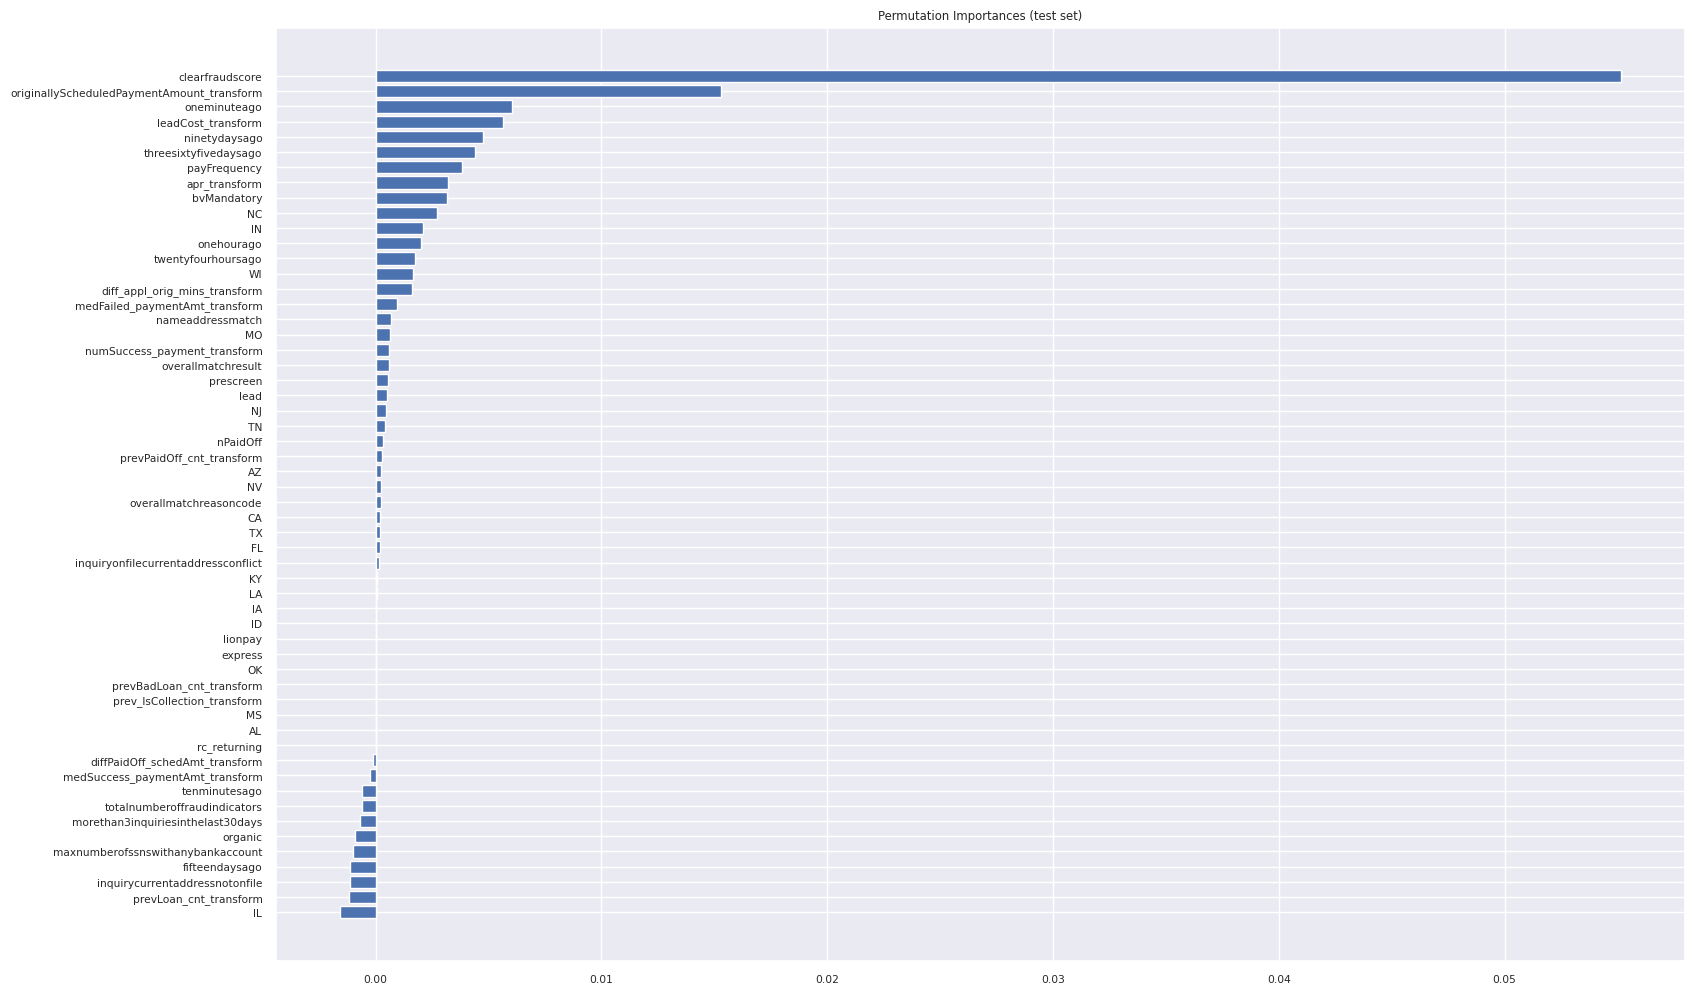

In [ ]:
# result = permutation_importance(
#     best_rf_classifier, X_test_, y_test_, n_repeats=10, random_state=11, n_jobs=2
# )

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(17,10))
ax.barh(X_test_.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

From the permutation importances analysis above, it is observed that features listed below has negative to 0 permutation importances, indicating the features do not contribute much in the prediction.

*   KY
*   LA
*   IA
*   ID
*   Lion Pay
*   Express
*   OK
*   Previous Bad Loan Count (Transformed)
*   Previous Payment is collection (Transformed)
*   MS
*   AL
*   RC Returning
*   Difference between Paid Off Amount and Scheduled Amount (Transformed)
*   Median of Success Payment Amount (Transformed)
*   Number of unique inquiries for the consumer seen by Clarity in the last 10 minutes
*   Total Number of unique fraud indicators
*   More than 3 inquiries in the last 30 days, true or false
*   Organic Flag
*   Max Number of unique SSNs with any bank account
*   Number of unique inquiries for the consumer seen by Clarity in the last 15 days
*   Inquiry current address not on-file, true or false
*   Previous Loan Count (Transformed)


In [ ]:
X_col_v2 = ['inquiryonfilecurrentaddressconflict', 'FL', 'TX', 'CA',
       'overallmatchreasoncode', 'NV', 'AZ', 'prevPaidOff_cnt_transform',
       'nPaidOff', 'TN', 'NJ', 'lead', 'prescreen', 'overallmatchresult',
       'numSuccess_payment_transform', 'MO', 'nameaddressmatch',
       'medFailed_paymentAmt_transform', 'diff_appl_orig_mins_transform', 'WI',
       'twentyfourhoursago', 'onehourago', 'IN', 'NC', 'bvMandatory',
       'apr_transform', 'payFrequency', 'threesixtyfivedaysago',
       'ninetydaysago', 'leadCost_transform', 'oneminuteago',
       'originallyScheduledPaymentAmount_transform', 'clearfraudscore']

X_train_ = X_train[X_col_v2]
y_train_ = y_train

X_test_ = X_test[X_col_v2]
y_test_ = y_test

In [ ]:
param_grid = {
    'max_depth': [5,7,9,12,15,20,30],
    'n_estimators': [50,100, 150, 200],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],

}

rf = RandomForestClassifier(n_jobs=-1,random_state=11)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_, y_train_)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best Estimator: RandomForestClassifier(max_depth=12, min_samples_leaf=4, n_estimators=150,
                       n_jobs=-1, random_state=11)


In [ ]:
f1_list = []
prec_list = []
recall_list = []
auc_list = []

f1_out_list = []
prec_out_list = []
recall_out_list = []
auc_out_list = []

# Best parameters
best_params = {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}

# Self-defined parameters
custom_params = {'n_jobs':-1,'random_state':11}

# Merge best_params and custom_params
merged_params = {**best_params, **custom_params}

# Create a Random Forest classifier with the merged parameters
best_rf_classifier = RandomForestClassifier(**merged_params)
best_rf_classifier.fit(X_train_,y_train_)

# y predict
y_pred = best_rf_classifier.predict(X_test_)
y_pred_out = best_rf_classifier.predict(X_out_time[X_col_v2])

# Test Result
f1 = f1_score(y_test_, y_pred)
prec = precision_score(y_test_, y_pred)
recall = recall_score(y_test_, y_pred)
auc = roc_auc_score(y_test_, y_pred)

# Out of time Result
f1_out = f1_score(y_out_time, y_pred_out)
prec_out = precision_score(y_out_time, y_pred_out)
recall_out = recall_score(y_out_time,y_pred_out)
auc_out = roc_auc_score(y_out_time, y_pred_out)

# Test Result append
f1_list.append(f1)
prec_list.append(prec)
recall_list.append(recall)
auc_list.append(auc)

# Out of time Result append
f1_out_list.append(f1_out)
prec_out_list.append(prec_out)
recall_out_list.append(recall_out)
auc_out_list.append(auc_out)

In [ ]:
final_rf_perf = pd.DataFrame(zip(f1_list,prec_list,recall_list,auc_list,f1_out_list,prec_out_list,recall_out_list,auc_out_list),
                                  columns=['f1','precision','recall','auc','f1_out','precision_out','recall_out','auc_out']).T

final_rf_perf

0
f1             0.722478
precision      0.668886
recall         0.785404
auc            0.631464
f1_out         0.844810
precision_out  0.804952
recall_out     0.888821
auc_out        0.601235

# Post Model Analysis

We have performed post model analysis in out-time validation dataset, and the findings are as follow:

Final Loan Risk model able to capture **80%** (2,926 out of 3,635) of the precision and **89%** (2,926 out of 3,292)of the recall of bad loan. This can help to flag potential bad loaners and allow lenders to avoid approve and fund the loan to potential bad borrowers

In [ ]:
# Generate classification report
report = classification_report(y_out_time, y_pred_out,target_names=['Good Loan','Bad Loan'])

# Print the report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   Good Loan       0.47      0.31      0.38      1033
    Bad Loan       0.80      0.89      0.84      3292

    accuracy                           0.75      4325
   macro avg       0.64      0.60      0.61      4325
weighted avg       0.72      0.75      0.73      4325



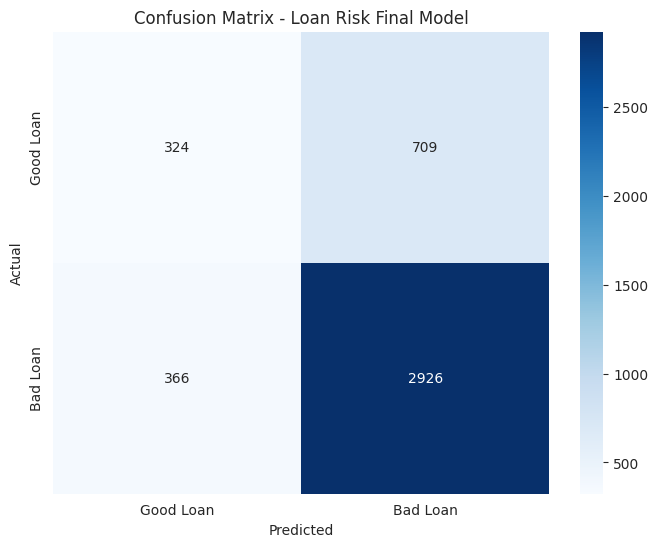

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_out_time, y_pred_out)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Good Loan','Bad Loan'], yticklabels=['Good Loan','Bad Loan'])
plt.title('Confusion Matrix - Loan Risk Final Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

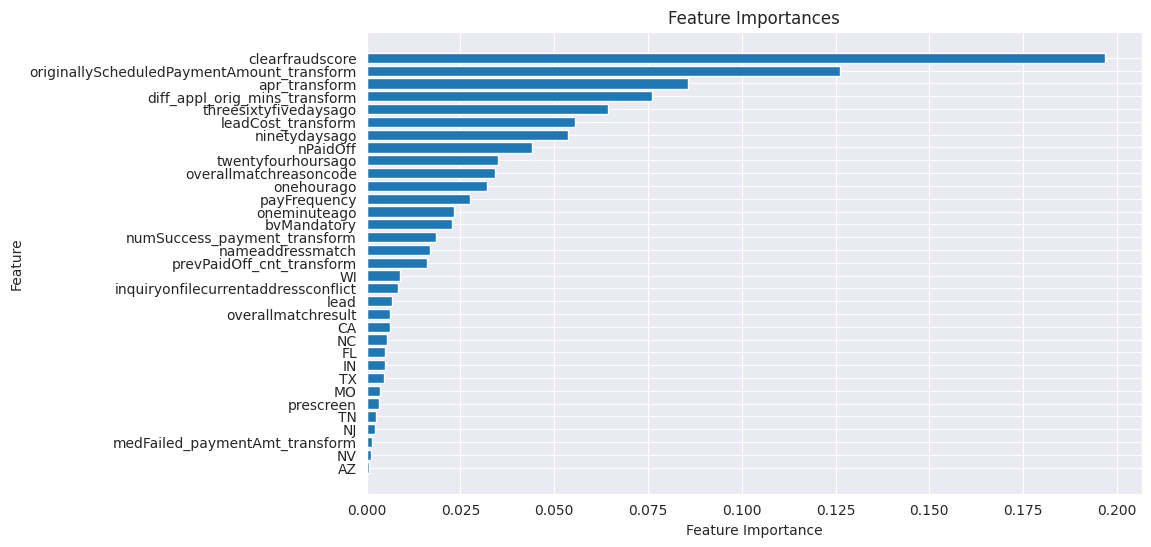

In [ ]:
# Get feature importances
importances = best_rf_classifier.feature_importances_
indices = np.argsort(importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X_col_v2[i] for i in indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

From the above feature importances chart, the top 5 important predictors are:
1. Clear Fraud Score
2. Originally Scheduled Payment Amount (Transformed)
3. Annual Percentage Rate (%) (Transformed)
4. Minutes difference between application datetime to originated datetime
5. Number of unique inquiries for the consumer seen by Clarity in the last 365 days

From the below Partial Dependence Plot, it is observed that
1. The higher the Clear Fraud Score, the **lower** the loan risk
2. The higher the Originally Scheduled Payment Amount Transform, the **higher** the loan risk
3. The higher the Annual Percentage Rate (%), the **higher** the loan risk
4. The higher the Number of unique inquiries for the consumer seen by Clarity in the last 365 days, the **higher** the loan risk


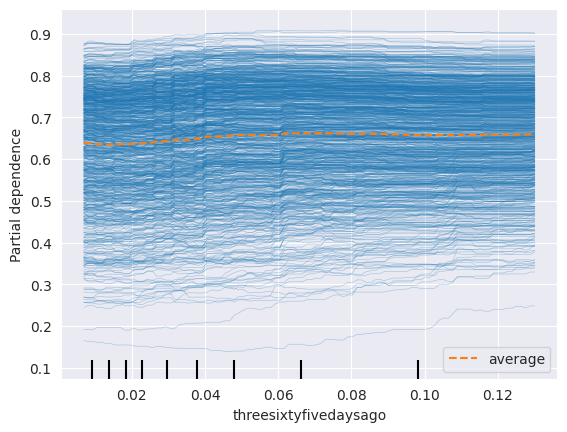

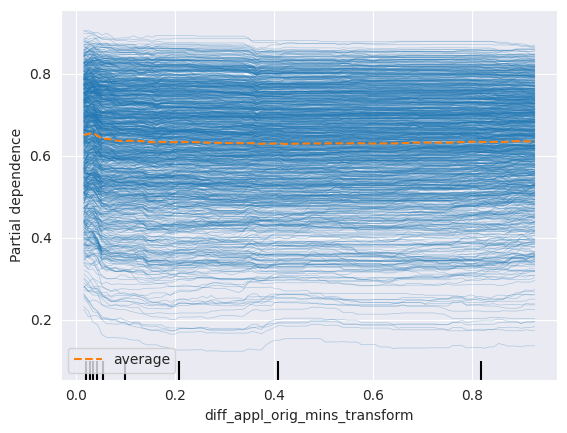

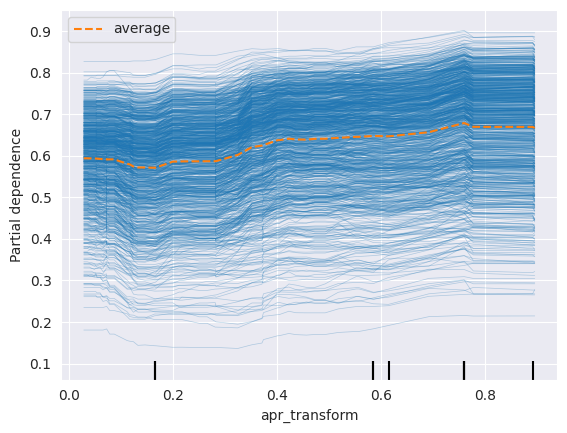

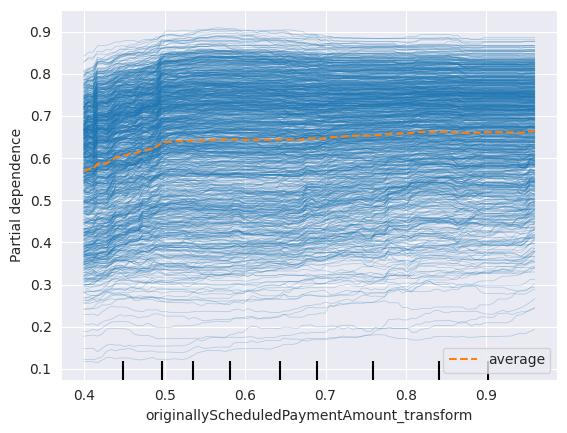

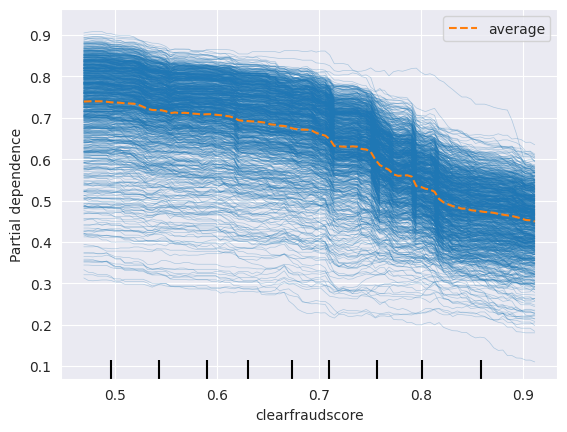

In [ ]:
for i in indices[-5:]:
  features = [i]
  PartialDependenceDisplay.from_estimator(best_rf_classifier, X_out_time[X_col_v2],features,kind='both')
  plt.show()

# Future Model Enhancement

Impute missing values for loan application that does not have clarity underwriting data after understanding the business context of how the fraud indicators and fraudscore being calculated.